# Histopathology-Image-Classification

## Setup and dependencies

In [4]:
# import library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

from sklearn.model_selection   import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition    import PCA
from sklearn.svm               import SVC
from sklearn.neighbors         import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix, f1_score,accuracy_score
from sklearn.pipeline          import Pipeline



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, optimizers,Input,regularizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier


# Setting the random seed
np.random.seed(5318)
tf.random.set_seed(5318)

# Clears the current Keras graph structure and frees memory.
keras.backend.clear_session()

## 1. Data loading, exploration, and preprocessing

### 1.1 Data loding

In [7]:
# Load the dataset training and test sets as numpy arrays
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

### 1.2 Data exploration
- Check structure of data. 
- Visualisation of target data.
- Check the class distribution to determine whether the data is balanced.

X_train shape: (32000, 28, 28, 3)
y_train shape: (32000,)
X_test shape: (8000, 28, 28, 3)
y_test shape: (8000,)
Unique labels in training set: [0 1 2 3 4 5 6 7 8]


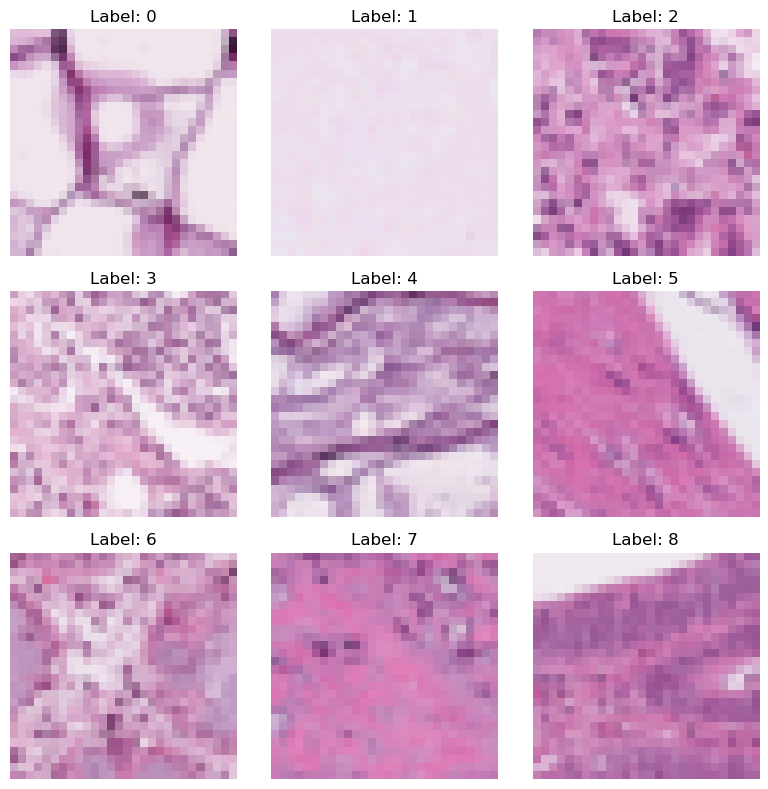

In [9]:
# Basic data checks
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Unique labels in training set:", np.unique(y_train))

# Visualize a few training examples
unique_labels = np.unique(y_train)
sample_indices = [np.where(y_train == label)[0][0] for label in unique_labels]

plt.figure(figsize=(8, 8))
for i, idx in enumerate(sample_indices):
    plt.subplot(3, 3, i + 1) 
    plt.imshow(X_train[idx])
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


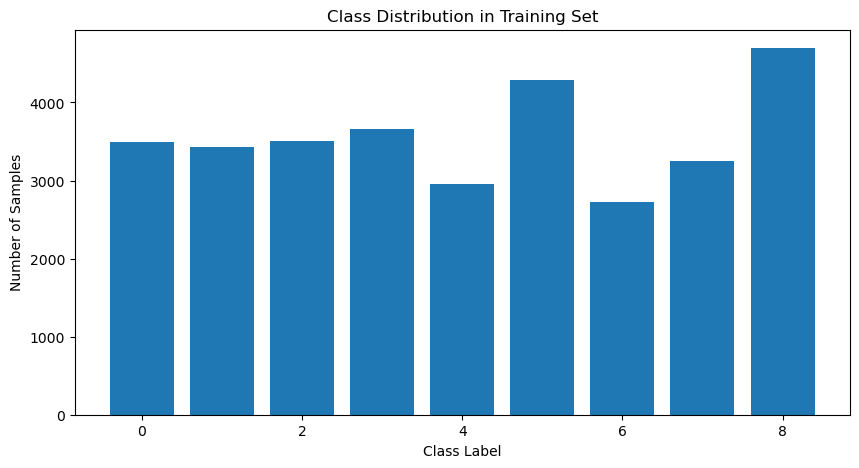

In [10]:
# Show class distribution
unique_classes, class_counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10,5))
plt.bar(unique_classes, class_counts)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.show()

Overall, the distribution of categories is fairly even, though not perfectly balanced; however, it is acceptable.

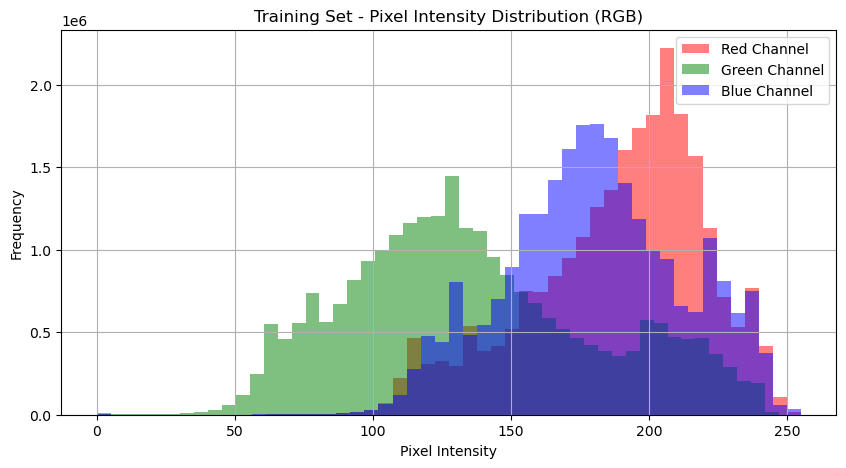

In [12]:
def plot_pixel_distribution(X, title_prefix="Train"):
    # Flatten the pixel values of all images: each channel is processed separately
    r = X[:, :, :, 0].ravel()
    g = X[:, :, :, 1].ravel()
    b = X[:, :, :, 2].ravel()

    plt.figure(figsize=(10, 5))
    plt.hist(r, bins=50, color='red', alpha=0.5, label='Red Channel')
    plt.hist(g, bins=50, color='green', alpha=0.5, label='Green Channel')
    plt.hist(b, bins=50, color='blue', alpha=0.5, label='Blue Channel')
    plt.title(f'{title_prefix} Set - Pixel Intensity Distribution (RGB)')
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_pixel_distribution(X_train, title_prefix="Training")

### 1.3 Data preprocessing
- The training set is further divided into training set and validation set. 
- Normalize the dataset to enhance the efficiency and performance of model training.
- processing data for SVM/MLP
    -  Flatten: Since the data are 28x28 colour images, for SVM and MLP models, the data need to be Flatten.
    -  Standardize: Reducing the effect of feature scale on SVM.
    -  PCA: Reduced dimensionality, reduced computation 
- One-hot labels for MLP/CNN
    - Facilitates calculation of cross entropy
    - Prevent models from misinterpreting labels as ‘ordered’ 

In [14]:
# Split training set into new training and validation sets
X_dev_train, X_val, y_dev_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=5318,
    stratify=y_train
)

In [15]:
# Normalize the image pixel values to [0,1]
X_dev_train = X_dev_train.astype('float32') / 255.0
X_val       = X_val.astype('float32') / 255.0
X_test      = X_test.astype('float32') / 255.0

#### 1.3.1 Processing data for SVM/MLP
- Flatten
- Standardize
- PCA:
    - PCA is highly sensitive to outliers, so they should be removed before performing the analysis.
    - Minimum number of principal components (dimensions) required to retain 90% of the variance of the original data.

In [17]:
# Flatten 
n_dev = X_dev_train.shape[0]
X_train_flat  = X_dev_train.reshape(n_dev, -1)
X_val_flat    = X_val.reshape (X_val.shape[0], -1)
X_test_flat   = X_test.reshape(X_test.shape[0], -1)

In [18]:
# Standardize
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat   = scaler.transform(X_val_flat)
X_test_flat  = scaler.transform(X_test_flat)

In [19]:
# Check outlier and remove
pca_viz = PCA(n_components=2, whiten=True, random_state=5318)
X_train_pca2d = pca_viz.fit_transform(X_train_flat)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outlier_labels = lof.fit_predict(X_train_pca2d)
X_train_clean = X_train_flat[outlier_labels == 1]
y_train_clean = y_dev_train[outlier_labels == 1]

In [20]:
# First assess the dimensions required to retain 90 per cent of the variance.
pca = PCA()
pca.fit(X_train_clean)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.90) + 1
d

199

In [21]:
# PCA for reducing noise
pca = PCA(n_components=d, whiten=True, random_state=5318)
X_train_pca = pca.fit_transform(X_train_clean)
X_val_pca   = pca.transform(X_val_flat)
X_test_pca  = pca.transform(X_test_flat)

#### 1.3.2 One-hot labels for MLP/CNN

In [78]:
# For neural networks (MLP, CNN) - one-hot encoding
y_train_clean_1hot = tf.keras.utils.to_categorical(y_train_clean).astype(np.float32)
y_train_1hot = tf.keras.utils.to_categorical(y_dev_train).astype(np.float32)
y_val_1hot   = tf.keras.utils.to_categorical(y_val).astype(np.float32)
y_test_1hot  = tf.keras.utils.to_categorical(y_test).astype(np.float32)


### 1.4 Examples of preprocessed data
- Printing the final data structure
- Visualisation of data after PCA
- Visualisation of data after one-hot is performed

In [25]:
# Final output check
print("\nFinal output shapes:")
print("X_train_pca:", X_train_pca.shape)
print("y_train_clean:", y_train_clean.shape)
print("y_train_clean_1hot:", y_train_clean_1hot.shape)
print("\nX_val_pca:",   X_val_pca.shape)
print("y_val:",   y_val.shape)
print("\nX_test_pca:",  X_test_pca.shape)
print("y_test:",   y_test.shape)
print("\nX_dev_train:", X_dev_train.shape)
print("y_train_1hot:", y_train_1hot.shape)
print("\nX_val:",       X_val.shape)
print("y_val_1hot:",       y_val_1hot.shape)
print("\nX_test:",      X_test.shape)
print("y_test_1hot:",       y_test_1hot.shape)


Final output shapes:
X_train_pca: (24320, 199)
y_train_clean: (24320,)
y_train_clean_1hot: (24320, 9)

X_val_pca: (6400, 199)
y_val: (6400,)

X_test_pca: (8000, 199)
y_test: (8000,)

X_dev_train: (25600, 28, 28, 3)
y_train_1hot: (25600, 9)

X_val: (6400, 28, 28, 3)
y_val_1hot: (6400, 9)

X_test: (8000, 28, 28, 3)
y_test_1hot: (8000, 9)


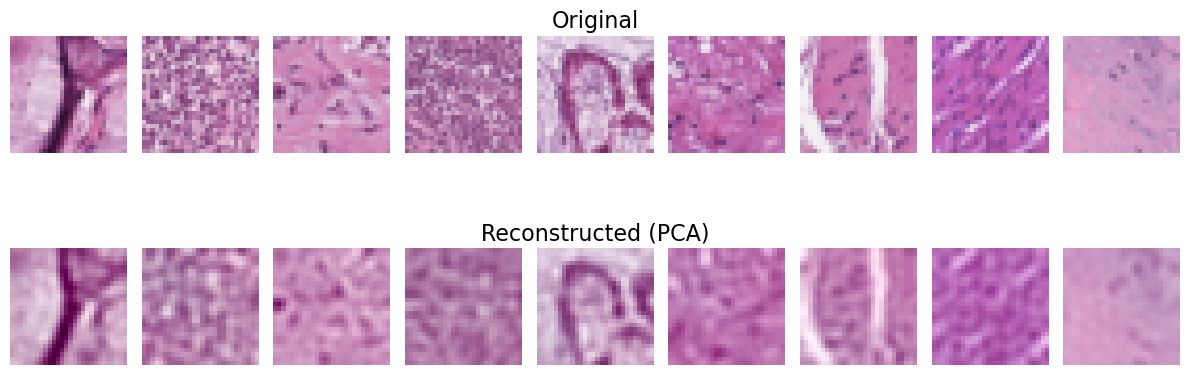

In [26]:
# Examples of PCA Reconstruction 
# Select random samples from cleaned training data
indices_recon = np.random.choice(X_train_pca.shape[0], size=9, replace=False)
X_train_clean_img = X_dev_train[outlier_labels == 1]
orig_imgs = X_train_clean_img[indices_recon]

# Inverse PCA + inverse scaling
recon_flat = pca.inverse_transform(X_train_pca)
recon_flat = scaler.inverse_transform(recon_flat)
recon_imgs = recon_flat.reshape(-1, 28, 28, 3)[indices_recon]

plt.figure(figsize=(12,5))
for i in range(9):
    # Original
    plt.subplot(2, 9, i+1)
    plt.imshow(orig_imgs[i])
    plt.axis('off')
    if i == 4:
        plt.title("Original", fontsize=16)
    # Reconstructed
    plt.subplot(2, 9, 9 + i + 1)
    plt.imshow(np.clip(recon_imgs[i], 0, 1))
    plt.axis('off')
    if i == 4:
        plt.title("Reconstructed (PCA)", fontsize=16)
plt.tight_layout()
plt.show()

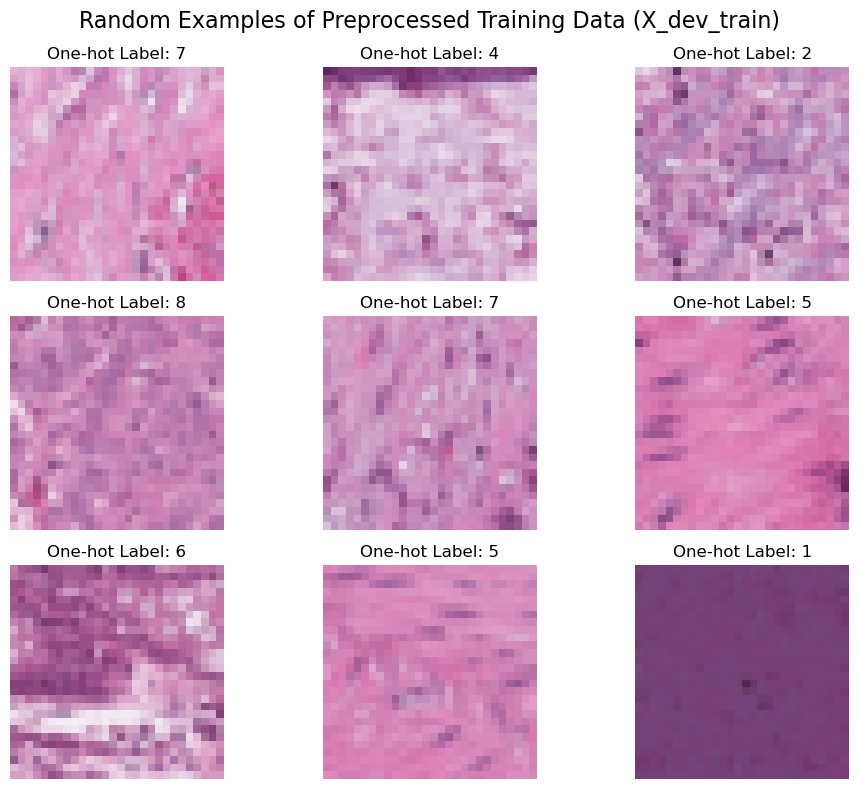

In [27]:
# Randomly select 9 samples for neural network dataset (one-hot labels) 

random_indices_cat = np.random.choice(X_dev_train.shape[0], size=9, replace=False)

plt.figure(figsize=(10, 8))
for i, idx in enumerate(random_indices_cat):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_dev_train[idx])
    label = np.argmax(y_train_1hot[idx])  # Decode from one-hot
    plt.title(f"One-hot Label: {label}")
    plt.axis('off')
plt.suptitle('Random Examples of Preprocessed Training Data (X_dev_train)', fontsize=16)
plt.tight_layout()
plt.show()


## 2. Algorithm design and setup

### 2.1 Definition of assessment indicators
- Accuracy: Proportion of overall measurements correctly classified
- Macro F1-score: 
- Micro F1-score
- Confusion Matrix

In [30]:
'''
    Parameters.
        y_true: array-like, true labels
        y_pred: array-like, predicted labels
        model_name: str, model name to be used in print headers
'''
def evaluate_predictions(y_true, y_pred, model_name="Model"):
     # Automatically determine if one-hot encoding and convert to hashtags
    def is_one_hot(y):
        return isinstance(y, np.ndarray) and y.ndim == 2 and np.all((y == 0) | (y == 1)) and np.all(y.sum(axis=1) == 1)

    def to_label(y):
        return np.argmax(y, axis=1) if is_one_hot(y) else y

     # Handling tag formats
    y_true = to_label(y_true)
    y_pred = to_label(y_pred)
    
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')
    
    print(f"========== {model_name} Evaluation ==========")
    print(classification_report(y_true, y_pred, digits=4))
    print(f"Micro F1     : {micro_f1:.4f}")
    create_CM(y_true, y_pred, model_name)

def create_CM(y_true, y_pred,model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    # plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

### 2.2 Support Vector Machine
- Select 'rbf' as kernel because it can capture complex non-linear relationship.
- Set ‘gamma’ to 0.01 and ‘C’ as default parameter.
- Verification of model performance on the validation and test sets.

In [32]:
svm = SVC(kernel="rbf", gamma=0.01)
svm.fit(X_train_pca, y_train_clean)

SVC(gamma=0.01)

========== SVM Validation Evaluation ==========
              precision    recall  f1-score   support

           0     0.8459    0.7865    0.8151       698
           1     0.9643    0.8673    0.9133       686
           2     0.4779    0.3081    0.3747       701
           3     0.7776    0.5787    0.6635       731
           4     0.5836    0.3610    0.4461       590
           5     0.6039    0.4336    0.5047       858
           6     0.2265    0.3700    0.2809       546
           7     0.4668    0.3564    0.4042       651
           8     0.3914    0.7370    0.5113       939

    accuracy                         0.5459      6400
   macro avg     0.5931    0.5332    0.5460      6400
weighted avg     0.5958    0.5459    0.5525      6400

Micro F1     : 0.5459


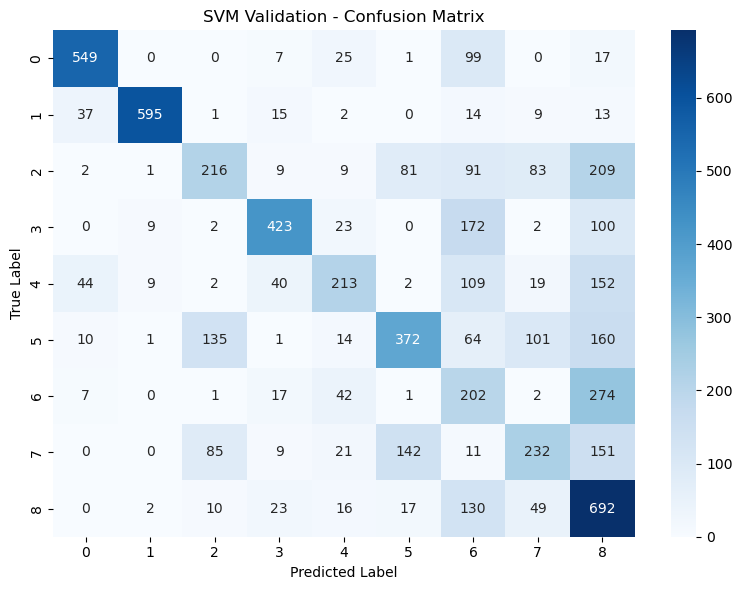

In [33]:
# Check performance on Validation set
svm_y_val_pred = svm.predict(X_val_pca)
evaluate_predictions(y_val, svm_y_val_pred, model_name="SVM Validation")

========== SVM Test Evaluation ==========
              precision    recall  f1-score   support

           0     0.8542    0.7721    0.8111       873
           1     0.9587    0.8928    0.9246       858
           2     0.4957    0.3284    0.3951       877
           3     0.7920    0.5832    0.6717       914
           4     0.5366    0.3582    0.4296       737
           5     0.6242    0.4618    0.5308      1072
           6     0.2376    0.3944    0.2966       682
           7     0.4656    0.3665    0.4102       813
           8     0.4041    0.7232    0.5185      1174

    accuracy                         0.5545      8000
   macro avg     0.5965    0.5423    0.5542      8000
weighted avg     0.6008    0.5545    0.5615      8000

Micro F1     : 0.5545


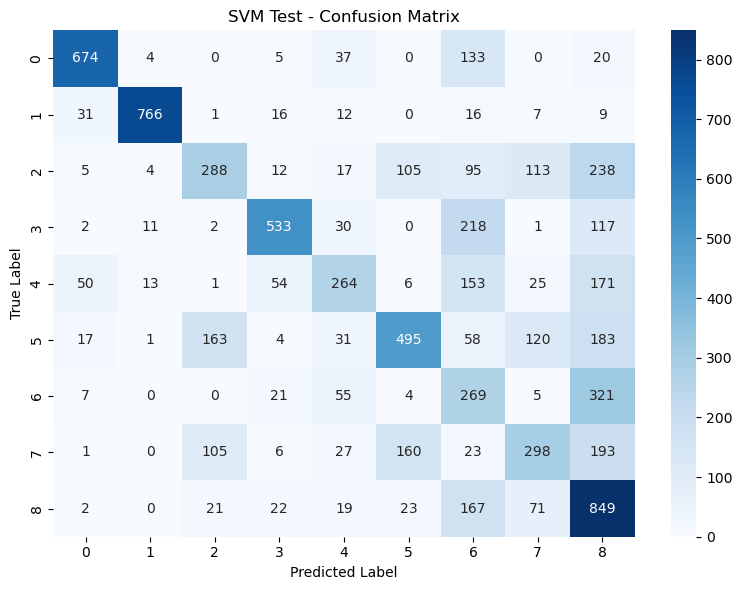

In [34]:
# Check performance on Test set
svm_y_test_pred = svm.predict(X_test_pca)
evaluate_predictions(y_test, svm_y_test_pred, model_name="SVM Test")

### 2.3 Fully connected neural network
- Define MLP model
    - Define a five-layer neural network in which the hidden layer is structured as [512,256,128].
    - Use ReLU activiation to capture non-linear relationship.
    - Use 30% Dropout to prevent overfit.
    - Use softmax as the final activation function for classification.
    - Use Adam as an optimizer.
    - Use 'categorical_crossentropy' to calculate loss between true value and predict value.
- Improve MLP model
    - Add L2 regularization to prevent overfit

#### 2.3.1 Define MLP model

In [37]:
# Define MLP model
mlp_model = Sequential([
    Input(shape=(X_train_pca.shape[1],)),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(9, activation='softmax')
])

# Compilation model
mlp_model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [38]:
# Train the MLP model
mlp_history = mlp_model.fit(X_train_pca, y_train_clean_1hot, epochs=20,
                            batch_size=64,
                            validation_data=(X_val_pca, y_val_1hot))

Epoch 1/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2489 - loss: 1.9763 - val_accuracy: 0.5144 - val_loss: 1.2731
Epoch 2/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4845 - loss: 1.3105 - val_accuracy: 0.5616 - val_loss: 1.1694
Epoch 3/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5528 - loss: 1.1562 - val_accuracy: 0.5800 - val_loss: 1.1138
Epoch 4/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 1.0627 - val_accuracy: 0.6000 - val_loss: 1.0728
Epoch 5/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6385 - loss: 0.9696 - val_accuracy: 0.6095 - val_loss: 1.0512
Epoch 6/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6577 - loss: 0.9025 - val_accuracy: 0.6206 - val_loss: 1.0383
Epoch 7/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6807 - loss: 0.8367 - val_accuracy: 0.6311 - val_loss: 1.0261
Epoch 8/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7004 - loss: 0.7924 - val_accuracy: 0.

========== MLP Test Evaluation ==========
              precision    recall  f1-score   support

           0     0.8416    0.9129    0.8758       873
           1     0.9797    0.9021    0.9393       858
           2     0.5517    0.4504    0.4959       877
           3     0.8463    0.8435    0.8449       914
           4     0.5295    0.6214    0.5718       737
           5     0.6679    0.6866    0.6771      1072
           6     0.4289    0.2786    0.3378       682
           7     0.4391    0.5055    0.4700       813
           8     0.6031    0.6627    0.6315      1174

    accuracy                         0.6637      8000
   macro avg     0.6542    0.6515    0.6493      8000
weighted avg     0.6621    0.6637    0.6599      8000

Micro F1     : 0.6637


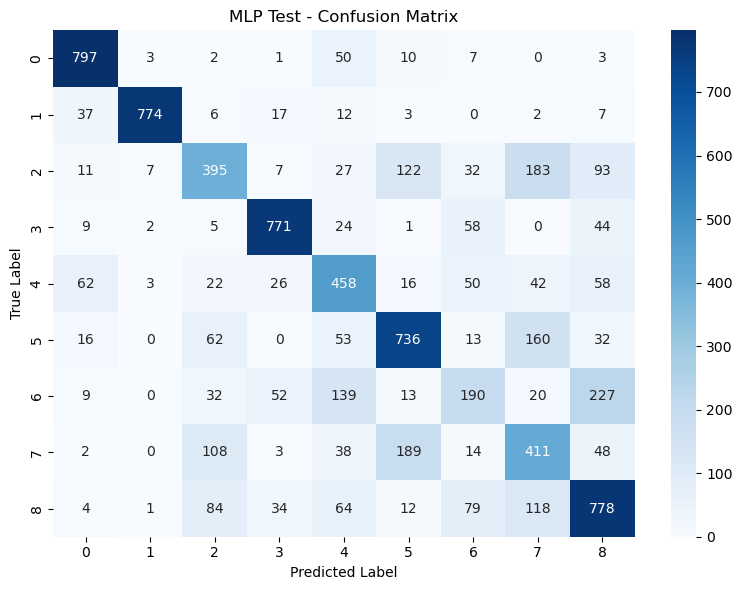

In [39]:
# predict result
mlp_pred = mlp_model.predict(X_test_pca, batch_size=64, verbose=0)
# The output of converting softmax
mlp_pred_labels = np.argmax(mlp_pred, axis=1)
# Output the overall result
evaluate_predictions(y_test_1hot, mlp_pred_labels, model_name="MLP Test")

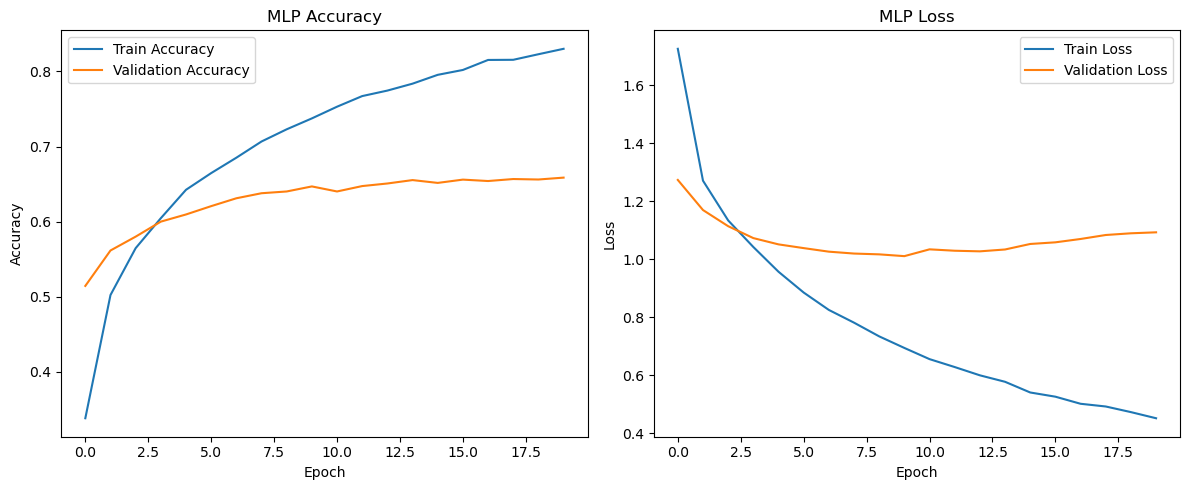

In [40]:
# Visual training process
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(mlp_history.history['accuracy'], label='Train Accuracy')
plt.plot(mlp_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(mlp_history.history['loss'], label='Train Loss')
plt.plot(mlp_history.history['val_loss'], label='Validation Loss')
plt.title('MLP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#### 2.3.2 Improved MLP model
- To address severe overfitting, increasing L2 regularization effectively mitigates the issue.

In [42]:
# improved MLP model (Add L2 regularization)
def create_improved_mlp_model():
    model = Sequential([
        Input(shape=(X_train_pca.shape[1],)),
        Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(1e-4)),
        Dropout(0.3),
        Dense(9, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Stop the configuration in advance
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Model training
improved_mlp_model = create_improved_mlp_model()
history = improved_mlp_model.fit(
    X_train_pca, y_train_clean_1hot,
    validation_data=(X_val_pca, y_val_1hot),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/50
380/380 - 3s - 7ms/step - accuracy: 0.3312 - loss: 2.1070 - val_accuracy: 0.4864 - val_loss: 1.5139
Epoch 2/50
380/380 - 2s - 5ms/step - accuracy: 0.4736 - loss: 1.5480 - val_accuracy: 0.5487 - val_loss: 1.3544
Epoch 3/50
380/380 - 2s - 5ms/step - accuracy: 0.5391 - loss: 1.3816 - val_accuracy: 0.5839 - val_loss: 1.2673
Epoch 4/50
380/380 - 2s - 5ms/step - accuracy: 0.5812 - loss: 1.2738 - val_accuracy: 0.6097 - val_loss: 1.2175
Epoch 5/50
380/380 - 2s - 5ms/step - accuracy: 0.6090 - loss: 1.1993 - val_accuracy: 0.6187 - val_loss: 1.1885
Epoch 6/50
380/380 - 2s - 5ms/step - accuracy: 0.6387 - loss: 1.1302 - val_accuracy: 0.6392 - val_loss: 1.1608
Epoch 7/50
380/380 - 2s - 5ms/step - accuracy: 0.6627 - loss: 1.0685 - val_accuracy: 0.6430 - val_loss: 1.1525
Epoch 8/50
380/380 - 2s - 5ms/step - accuracy: 0.6843 - loss: 1.0163 - val_accuracy: 0.6467 - val_loss: 1.1432
Epoch 9/50
380/380 - 2s - 5ms/step - accuracy: 0.7030 - loss: 0.9727 - val_accuracy: 0.6552 - val_loss: 1.1430
E

========== Improved MLP Test Evaluation ==========
              precision    recall  f1-score   support

           0     0.8138    0.9462    0.8750       873
           1     0.9834    0.8974    0.9385       858
           2     0.6335    0.4572    0.5311       877
           3     0.7684    0.8567    0.8101       914
           4     0.4994    0.5929    0.5422       737
           5     0.6719    0.6800    0.6759      1072
           6     0.4008    0.3079    0.3483       682
           7     0.4775    0.5092    0.4929       813
           8     0.5847    0.5971    0.5908      1174

    accuracy                         0.6589      8000
   macro avg     0.6481    0.6494    0.6450      8000
weighted avg     0.6560    0.6589    0.6539      8000

Micro F1     : 0.6589


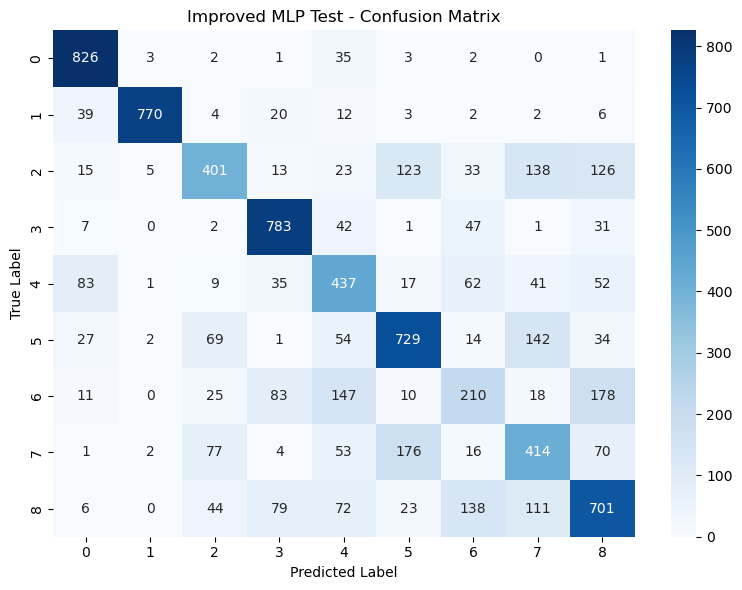

In [43]:
# predict result
improved_mlp_pred = improved_mlp_model.predict(X_test_pca, batch_size=64, verbose=0)
# The output of converting softmax
improved_mlp_pred_labels = np.argmax(improved_mlp_pred, axis=1)
# Output the overall result
evaluate_predictions(y_test_1hot, improved_mlp_pred_labels, model_name="Improved MLP Test")

In [44]:
# Evaluate MLP on test set
test_loss, test_accuracy = improved_mlp_model.evaluate(X_test_pca, y_test_1hot)
print(f"Improved MLP Test Accuracy: {test_accuracy:.4f}")
print(f"Improved MLP Test Loss: {test_loss:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6635 - loss: 1.1415
Improved MLP Test Accuracy: 0.6589
Improved MLP Test Loss: 1.1447


### 2.4 Convolutional neural network
- Define construct and procession of convolutional neural network
    - Input Layer
    - Convolution + Pooling Block 1 
        - 3×3 convolutional kernel, output 32 feature maps
        - 2×2 Maximum pooling to reduce space size to half (14×14)
    - Convolution + Pooling Block 2
        - 3×3 convolutional kernel, output 64 feature maps
        - 2×2 Maximum pooling to reduce space size to half (7×7)
    - Flatten
        - Flatten data into a one-dimensional vector
    - Full connection
        - Using ReLU activation to Find unlinear relationship
        - Dropout 30% data for reduce overfit
    - Output layer with Softmax
- Using 'categorical_crossentropy' to calculate loss and 'Adam' to update weights.
- Add early stop to reduce overfit
    - Use validation data as monitor 
    - Tolerates up to 5 non-upgrades

In [46]:
# Define construct of CNN
cnn = Sequential([
    layers.Input((28,28,3)),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64,3,activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(9, activation='softmax')
])
# Define specify optimizer, loss function, and evaluation metric
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Define EarlyStopping to reduce overfit
cnn_early_stop = EarlyStopping(
    monitor='val_accuracy',     # Monitor validation set accuracy
    patience=5,                 # Tolerates up to 5 non-upgrades
    mode='max',                 # val_accuracy gets bigger and better
    restore_best_weights=True  # Return to optimal weights when training stops
)
# Train the model for 20 epochs with batch size 64
cnn.fit(X_dev_train, y_train_1hot, validation_data=(X_val, y_val_1hot), epochs=50, batch_size=64, callbacks=[cnn_early_stop])

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.2775 - loss: 1.8760 - val_accuracy: 0.5189 - val_loss: 1.2426
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5353 - loss: 1.2307 - val_accuracy: 0.6284 - val_loss: 1.0165
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6137 - loss: 1.0512 - val_accuracy: 0.6677 - val_loss: 0.8966
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6555 - loss: 0.9327 - val_accuracy: 0.7016 - val_loss: 0.8267
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6845 - loss: 0.8733 - val_accuracy: 0.7200 - val_loss: 0.7792
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7018 - loss: 0.8248 - val_accuracy: 0.7159 - val_loss: 0.7688
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7153 - loss: 0.7860 - val_accuracy: 0.7081 - val_loss: 0.7883
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7215 - loss: 0.7790 - val_accu

========== CNN Test Evaluation ==========
              precision    recall  f1-score   support

           0     0.8915    0.9691    0.9286       873
           1     0.9709    0.9347    0.9525       858
           2     0.6775    0.5941    0.6330       877
           3     0.9654    0.9168    0.9405       914
           4     0.7463    0.7503    0.7483       737
           5     0.7033    0.8069    0.7515      1072
           6     0.6975    0.5645    0.6240       682
           7     0.5033    0.6544    0.5690       813
           8     0.8552    0.7342    0.7901      1174

    accuracy                         0.7755      8000
   macro avg     0.7790    0.7695    0.7708      8000
weighted avg     0.7851    0.7755    0.7770      8000

Micro F1     : 0.7755


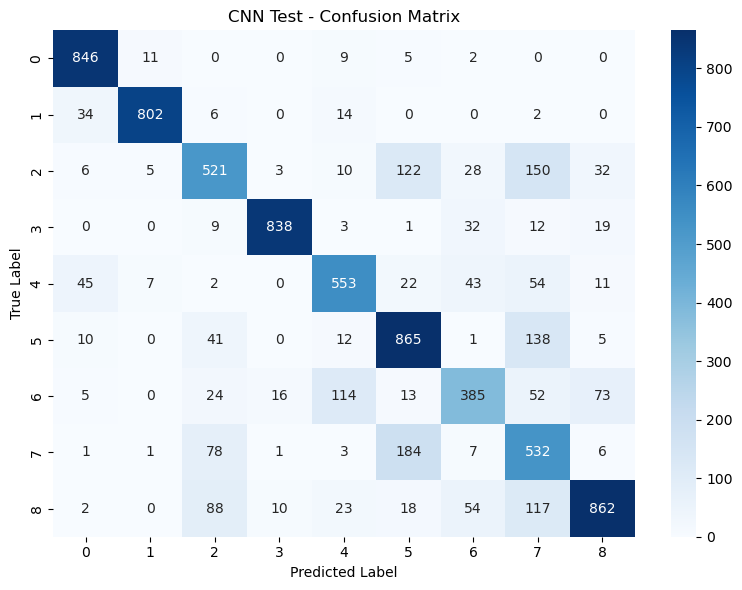

In [47]:
# predict result
cnn_pred = cnn.predict(X_test, batch_size=64, verbose=0)
# The output of converting softmax
cnn_pred_labels = np.argmax(cnn_pred, axis=1)
# Output the overall result
evaluate_predictions(y_test_1hot, cnn_pred_labels, model_name="CNN Test")

In [48]:
# Print train result
print("CNN test acc:", cnn.evaluate(X_test, y_test_1hot, verbose=0)[1])

CNN test acc: 0.7754999995231628


## 3. Hyperparameter tuning

### 3.1 Support Vector Machine
- Define Hyperparameters.
- Using grid search to best parameters based on Accuracy.
- Based on the results of the grid search, a heatmap is used to visualize the accuracy across different parameter combinations.
- Showing the runtime and result of each combination.

#### 3.1.1 Grid search to best parameters

In [52]:
# Define parameters
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1, 10]
}
# Setting pipeline to train
svm_pipeline = Pipeline([
    ('svm', SVC(kernel='rbf'))
])

In [53]:
# Grid search 
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=10, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_pca, y_train_clean)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10, estimator=Pipeline(steps=[('svm', SVC())]), n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10, 100],
                         'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1, 10]},
             scoring='accuracy', verbose=2)

#### 3.1.2 Visualize the result of different parameter combinations

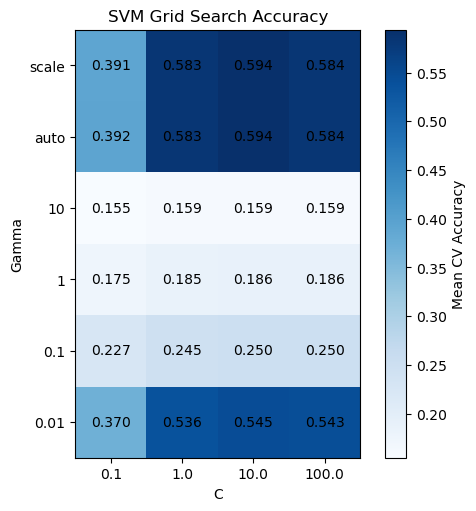

In [55]:
svm_results = grid_search.cv_results_

# Extract unique hyperparameter values
Cs     = sorted(np.unique(svm_results['param_svm__C'].astype(float)))
# Convert all gamma values to string to avoid mixed-type sorting
gammas = sorted(np.unique(svm_results['param_svm__gamma'].astype(str)))

# Build score matrix for (C, gamma)
score_mat = np.zeros((len(gammas), len(Cs)))
for i, gamma in enumerate(gammas):
    for j, C in enumerate(Cs):
        mask = (
            (svm_results['param_svm__C'] == C) &
            (svm_results['param_svm__gamma'].astype(str)==gamma)
        )
        score_mat[i, j] = svm_results['mean_test_score'][mask][0]

# Plot SVM heatmap
fig2, ax2 = plt.subplots(figsize=(6,5), constrained_layout=True)
im2 = ax2.imshow(score_mat, origin='lower', cmap='Blues',
                   vmin=score_mat.min(), vmax=score_mat.max())
ax2.set_xticks(np.arange(len(Cs)))
ax2.set_xticklabels(Cs)
ax2.set_yticks(np.arange(len(gammas)))
ax2.set_yticklabels(gammas)
ax2.set_xlabel('C')
ax2.set_ylabel('Gamma')
ax2.set_title('SVM Grid Search Accuracy')

# Annotate cells
for i in range(len(gammas)):
    for j in range(len(Cs)):
        ax2.text(j, i, f"{score_mat[i,j]:.3f}", ha='center', va='center')

# Colorbar
cbar2 = fig2.colorbar(im2, ax=ax2)
cbar2.set_label('Mean CV Accuracy')

plt.show()

In [56]:
# Print Best parameters and F1 macro result
print("Best parameters:", grid_search.best_params_)
print("Best CV F1 macro:", grid_search.best_score_)

Best parameters: {'svm__C': 10, 'svm__gamma': 'scale'}
Best CV F1 macro: 0.5939967105263159


#### 3.1.3 Show the runtime and result of different parameter combinations

In [58]:
# Showing the runtime and result of each combination.
# Turn result into a DataFrame
svm_df = pd.DataFrame(grid_search.cv_results_)

# set columns
svm_df = svm_df[['params',
         'mean_test_score','std_test_score',
         'mean_fit_time','std_fit_time',
         'mean_score_time','std_score_time']]

#  Sort by average test score
svm_df = svm_df.sort_values('mean_test_score', ascending=False)

# Show Top 10
svm_df = svm_df.head(10)

# Reset the index and have it start at 1
svm_df = svm_df.reset_index(drop=True)
svm_df.index = svm_df.index + 1

svm_df

,params,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
1,"{'svm__C': 10, 'svm__gamma': 'scale'}",0.593997,0.008127,204.090573,0.863547,11.684897,0.174618
2,"{'svm__C': 10, 'svm__gamma': 'auto'}",0.593914,0.008081,203.685945,0.539799,11.743745,0.236351
3,"{'svm__C': 100, 'svm__gamma': 'auto'}",0.583512,0.007294,203.531313,0.487287,11.752652,0.358923
4,"{'svm__C': 100, 'svm__gamma': 'scale'}",0.583512,0.007350,204.037246,0.932470,11.536879,0.181644
5,"{'svm__C': 1, 'svm__gamma': 'scale'}",0.583141,0.005777,174.956109,0.893790,12.257597,0.323829
6,"{'svm__C': 1, 'svm__gamma': 'auto'}",0.583100,0.005971,175.822382,5.571959,12.415691,0.768102
7,"{'svm__C': 10, 'svm__gamma': 0.01}",0.545230,0.008834,233.845933,1.232839,11.777391,0.207648
8,"{'svm__C': 100, 'svm__gamma': 0.01}",0.542969,0.009232,233.382529,1.215943,11.650467,0.228227
9,"{'svm__C': 1, 'svm__gamma': 0.01}",0.536184,0.008623,215.116397,8.219311,12.091392,0.464788
10,"{'svm__C': 0.1, 'svm__gamma': 'auto'}",0.391530,0.005658,200.873029,5.829296,12.510623,0.408309


### 3.2 Fully connected neural network
- Define Hyperparameters
    - The number of hidden layers: [512, 256, 128] and [512, 256, 128, 64].
    - Different of activation: 'ReLU' and 'Tanh'
    - Exploring the Impact of Different Dropout on Model:0.0, 0.3, 0.5
    - Exploring the different of learning rate on optimizer:1e-3, 1e-4
    - The different of batch size impact on Model: 64,128
-  Based on the results of the grid search, a heatmap is used to visualize the accuracy across different parameter combinations.
-  Showing the runtime and result of each combination

#### 3.2.1 Grid search to best parameters

In [61]:
def create_mlp_model(hidden_units=[512,256], dropout_rate=0.3, learning_rate=1e-3,
                     activation='relu', kernel_regularizer=None):
    tf.keras.backend.clear_session()
    model = Sequential([
        # Determine input dimension and number of classes from data variables
        Input(shape=(X_train_pca.shape[1],)),
    ])
    # add hidden dense layers
    for units in hidden_units:
        if kernel_regularizer:
            model.add(layers.Dense(units, activation=activation,
                                    kernel_regularizer=kernel_regularizer))
        else:
            model.add(layers.Dense(units, activation=activation))
        model.add(layers.Dropout(dropout_rate))
    # Output layer
    model.add(layers.Dense(9, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [62]:
# Early stopping callback
mlp_early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Wrap model for scikit-learn
mlp_clf = KerasClassifier(model=create_mlp_model,
                          epochs=50, verbose=0,
                          callbacks=[mlp_early_stop])


In [82]:
# Define hyperparameter grid (tuning at least 3 parameters)
param_grid_mlp = {
    'model__hidden_units':      [[512, 256, 128],[512, 256, 128, 64]],
    'model__activation':        ['relu', 'tanh'],
    'model__dropout_rate':      [0.0, 0.3, 0.5],
    'model__learning_rate':     [1e-3, 1e-4],
    'model__kernel_regularizer': [regularizers.l2(1e-4)],
    'batch_size':               [64,128]
}

# Perform grid search with 3-fold CV
grid_mlp = GridSearchCV(mlp_clf, param_grid_mlp, cv=3, scoring='accuracy', n_jobs=1)
grid_mlp.fit(X_train_pca, y_train_clean_1hot, 
         **{'validation_data': (X_val_pca, y_val_1hot)})

GridSearchCV(cv=3,
             estimator=KerasClassifier(callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x2a424bcb0>], epochs=50, model=<function create_mlp_model at 0x2a43d8040>, verbose=0),
             n_jobs=1,
             param_grid={'batch_size': [64, 128],
                         'model__activation': ['relu', 'tanh'],
                         'model__dropout_rate': [0.0, 0.3, 0.5],
                         'model__hidden_units': [[512, 256, 128],
                                                 [512, 256, 128, 64]],
                         'model__kernel_regularizer': [<keras.src.regularizers.regularizers.L2 object at 0x375d263c0>],
                         'model__learning_rate': [0.001, 0.0001]},
             scoring='accuracy')

#### 3.2.2 Visualize the result of different parameter combinations

In [83]:
# Extract best hyperparameters
best = grid_mlp.best_params_
fixed_lr = best['model__learning_rate']
fixed_bs = best['batch_size']
fixed_hu = tuple(best['model__hidden_units'])
fixed_act= best['model__activation']
fixed_dp = best['model__dropout_rate']

In [84]:
# Function to plot heatmap for hidden_units vs dropout_rate
# at specified (learning_rate, batch_size, activation)
def plot_hidden_vs_dropout(lr, bs, act, ax):
    ax.set_title(f"act={act}, lr={lr}, bs={bs}")
    hiddens = sorted(results['param_model__hidden_units']
                     .apply(lambda x: tuple(x)).unique())
    drops = sorted(results['param_model__dropout_rate'].astype(float).unique())
    mat = np.zeros((len(drops), len(hiddens)))
    for i, dp in enumerate(drops):
        for j, hu in enumerate(hiddens):
            mask = (
                (results['param_model__learning_rate']==lr) &
                (results['param_batch_size']==bs) &
                (results['param_model__activation']==act) &
                (results['param_model__dropout_rate']==dp) &
                (results['param_model__hidden_units']
                 .apply(lambda x: tuple(x))==hu)
            )
            mat[i,j] = results.loc[mask, 'mean_test_score'].values[0]
    im = ax.imshow(mat, origin='lower', cmap='Greens',
                   vmin=results['mean_test_score'].min(),
                   vmax=results['mean_test_score'].max())
    ax.set_xticks(np.arange(len(hiddens)))
    ax.set_xticklabels([str(list(x)) for x in hiddens], rotation=45)
    ax.set_yticks(np.arange(len(drops)))
    ax.set_yticklabels(drops)
    ax.set_xlabel('Hidden layer sizes')
    ax.set_ylabel('Dropout rate')
    for i in range(len(drops)):
        for j in range(len(hiddens)):
            ax.text(j, i, f"{mat[i,j]:.3f}", ha='center', va='center')
    return im

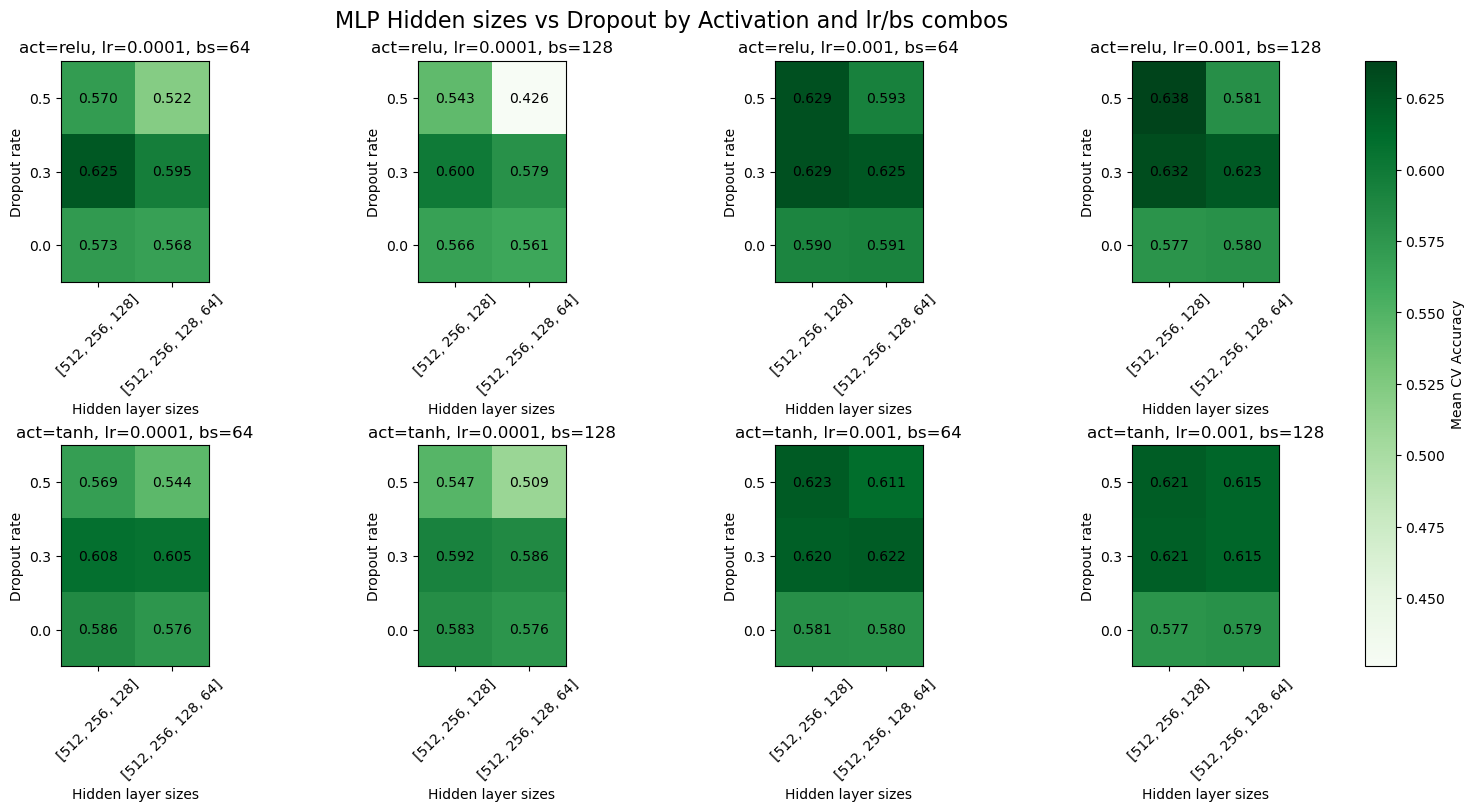

In [109]:
# Plot comparison for existing learning-rate & batch-size settings dynamically
results = pd.DataFrame(grid_mlp.cv_results_)
acts   = sorted(results['param_model__activation'].unique())
settings = list(results.groupby(['param_model__learning_rate','param_batch_size']).size().index)[:4]

fig, axes = plt.subplots(len(acts), len(settings), figsize=(4*len(settings), 4*len(acts)), constrained_layout=True)
for i, act in enumerate(acts):
    for j, (lr, bs) in enumerate(settings):
        ax = axes[i, j]
        im = plot_hidden_vs_dropout(lr, bs, act, ax)
        ax.set_title(f"act={act}, lr={lr}, bs={bs}")
        ax.set_xlabel('Hidden layer sizes')
        ax.set_ylabel('Dropout rate')
# add a single colorbar for all subplots
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), label='Mean CV Accuracy')
fig.suptitle('MLP Hidden sizes vs Dropout by Activation and lr/bs combos', fontsize=16)
plt.show()

In [111]:
# Print Best parameters and F1 macro result
print("Best parameters:", grid_mlp.best_params_)
print("Best CV F1 macro:", grid_mlp.best_score_)

Best parameters: {'batch_size': 128, 'model__activation': 'relu', 'model__dropout_rate': 0.5, 'model__hidden_units': [512, 256, 128], 'model__kernel_regularizer': <keras.src.regularizers.regularizers.L2 object at 0x375d263c0>, 'model__learning_rate': 0.001}
Best CV F1 macro: 0.638034255887055


#### 3.2.3 Show the runtime and result of different parameter combinations

In [113]:
# Showing the runtime and result of each combination.
# Turn result into a DataFrame
mlp_df = pd.DataFrame(grid_mlp.cv_results_)

# set columns
mlp_df = mlp_df[['params',
         'mean_test_score','std_test_score',
         'mean_fit_time','std_fit_time',
         'mean_score_time','std_score_time']]

#  Sort by average test score
mlp_df = mlp_df.sort_values('mean_test_score', ascending=False)

# Show Top 10
mlp_df = mlp_df.head(10)

# Reset the index and have it start at 1
mlp_df = mlp_df.reset_index(drop=True)
mlp_df.index = mlp_df.index + 1

mlp_df

,params,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
1,"{'batch_size': 128, 'model__activation': 'relu...",0.638034,0.005012,28.294833,1.941181,0.135575,0.002347
2,"{'batch_size': 128, 'model__activation': 'relu...",0.631537,0.007575,15.227730,2.268450,0.132940,0.001161
3,"{'batch_size': 64, 'model__activation': 'relu'...",0.629440,0.014675,38.400414,10.142914,0.175887,0.001905
4,"{'batch_size': 64, 'model__activation': 'relu'...",0.629358,0.006467,20.868157,2.171276,0.174614,0.000714
5,"{'batch_size': 64, 'model__activation': 'relu'...",0.625246,0.006587,33.124106,0.562786,0.194477,0.009395
6,"{'batch_size': 64, 'model__activation': 'relu'...",0.624547,0.005140,53.061680,0.372052,0.173776,0.001038
7,"{'batch_size': 128, 'model__activation': 'relu...",0.623149,0.006475,20.629510,2.015673,0.138975,0.000633
8,"{'batch_size': 64, 'model__activation': 'tanh'...",0.623026,0.007072,39.984932,3.192685,0.182695,0.003784
9,"{'batch_size': 64, 'model__activation': 'tanh'...",0.621710,0.006348,34.120596,5.169132,0.184805,0.000773
10,"{'batch_size': 128, 'model__activation': 'tanh...",0.620765,0.003293,28.420957,3.356992,0.137184,0.000937


### 3.3 Convolutional neural network
- Ablation study for reducing wastes a lot of computing resources
    - a.Define baseline model
    - b.Remove or keep Dropout
    - c.Reduce the number of convolution-pooling blocks
    - d.Replacement pooling method
    - e.Replacement activation function
    - f.Adjusting the number of fully connected layers
    - g.Add batch normalisation
- Hyperparameter tuning for finding best parameters
    - Finding optimal parameters based on the results of ablation study
- Based on the results of the grid search, a heatmap is used to visualize the accuracy across different parameter combinations.
- Showing the runtime and result of each combination.

#### 3.3.1 Ablation study

In [115]:
# Define function to create CNN model
def build_cnn(dp=0.3, learning_rate=1e-3,block=2,  kernel_size = 3, pool = 'max', act = 'relu', CL_size = 128, use_bn = False):
    # Define input layer
    layers_list = [layers.Input((28,28,3))]
    # Choice activation function 
    def add_conv_block(filters):
        layers_list.append(layers.Conv2D(filters, kernel_size))
        if use_bn:
            layers_list.append(layers.BatchNormalization())
        if act == 'leaky_relu':
            layers_list.append(layers.LeakyReLU(negative_slope=0.1))
        elif act == 'elu':
            layers_list.append(layers.ELU(alpha=1.0))
        else:  # default: relu
            layers_list.append(layers.Activation('relu'))
            
    # block1 conv + pool
    add_conv_block(32)
    layers_list.append(layers.MaxPool2D(pool_size=(2,2)) if pool=='max' else layers.AveragePooling2D(pool_size=(2,2)))
    # block2 conv + pool (option)
    if block > 1:
        add_conv_block(64)
        layers_list.append(layers.MaxPool2D(pool_size=(2,2)) if pool=='max' else layers.AveragePooling2D(pool_size=(2,2)))
    layers_list.append(layers.Flatten())
    # Batch Normalisation
    if use_bn:
        layers_list.append(layers.BatchNormalization())
    layers_list.append(layers.Dense(CL_size))
    if act == 'leaky_relu':
        layers_list.append(layers.LeakyReLU(negative_slope=0.1))
    elif act == 'elu':
        layers_list.append(layers.ELU(alpha=1.0))
    else:
        layers_list.append(layers.Activation('relu'))
    layers_list.append(layers.Dropout(dp))
    layers_list.append(layers.Dense(9, activation='softmax'))

    model = Sequential(layers_list)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [117]:
# Define function to campare two different model on Accuracy、Micro-F1、Macro-F1
def compare_models_metrics(y_true, y_pred1, y_pred2, y_pred3=None, model_names=None):
    #Accuracy, Micro-F1, Macro-F1 and draw a bar graph comparing the two or three models
    # Default model name
    if model_names is None:
        model_names = ["Model 1", "Model 2"] if y_pred3 is None else ["Model 1", "Model 2", "Model 3"]

    # Converting one-hot to one-dimensional data
    def to_label(y):
        return np.argmax(y, axis=1) if y.ndim > 1 else y
        
    
    y_true = to_label(y_true)
    y_pred1 = to_label(y_pred1)
    y_pred2 = to_label(y_pred2)
    if y_pred3 is not None:
        y_pred3 = to_label(y_pred3)
    # Calculation of indicators
    metrics = {
        "Accuracy": [
            accuracy_score(y_true, y_pred1),
            accuracy_score(y_true, y_pred2)
        ],
        "Micro-F1": [
            f1_score(y_true, y_pred1, average='micro'),
            f1_score(y_true, y_pred2, average='micro')
        ],
        "Macro-F1": [
            f1_score(y_true, y_pred1, average='macro'),
            f1_score(y_true, y_pred2, average='macro')
        ]
    }
    # Inclusion of a third model (if any)
    if y_pred3 is not None:
        metrics["Accuracy"].append(accuracy_score(y_true, y_pred3))
        metrics["Micro-F1"].append(f1_score(y_true, y_pred3, average='micro'))
        metrics["Macro-F1"].append(f1_score(y_true, y_pred3, average='macro'))
        
    # Prepare data for graphing
    metric_names = list(metrics.keys())
    x = np.arange(len(metric_names))  # Indicator location
    width = 0.25 # Column width

    fig, ax = plt.subplots(figsize=(9, 5))

    # Calculate the position of each bar and plot the bar for each model
    rects = []
    for i in range(len(model_names)):
        offset = (i - (len(model_names) - 1) / 2) * width
        values = [metrics[m][i] for m in metric_names]
        r = ax.bar(x + offset, values, width, label=model_names[i])
        rects.append(r)


    # Adding legends, titles and labels
    ax.set_ylabel('Score')
    ax.set_title('Model Comparison: Accuracy vs F1 Scores')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_names)
    ax.set_ylim(0, 1.05)
    ax.legend()

    # Displays the value on the column
    for rect_group in rects:
        for rect in rect_group:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom')
            
    plt.tight_layout()
    plt.show()

In [119]:
# Define EarlyStopping to reduce overfit
early_stop = EarlyStopping(
    monitor='val_accuracy',     # Monitor validation set accuracy
    patience=5,                 # Tolerates up to 5 non-upgrades
    mode='max',                 # val_accuracy gets bigger and better
    restore_best_weights=True  # Return to optimal weights when training stops
)
# Define epochs and batch size
EPOCHS = 50
BATCH_SIZE = 64

##### a.Define baseline model

In [122]:
# Define baseline model
cnn_baseline = build_cnn()
cnn_baseline.fit(X_dev_train, y_train_1hot, validation_data=(X_val, y_val_1hot), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stop])

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2962 - loss: 1.8513 - val_accuracy: 0.5202 - val_loss: 1.2594
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5151 - loss: 1.2873 - val_accuracy: 0.6303 - val_loss: 1.0077
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6010 - loss: 1.0761 - val_accuracy: 0.6423 - val_loss: 0.9582
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6470 - loss: 0.9733 - val_accuracy: 0.6514 - val_loss: 0.9446
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6725 - loss: 0.9076 - val_accuracy: 0.6866 - val_loss: 0.8572
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7014 - loss: 0.8328 - val_accuracy: 0.6686 - val_loss: 0.9127
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7024 - loss: 0.8173 - val_accuracy: 0.7441 - val_loss: 0.7103
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7243 - loss: 0.7677 - val_accu

========== CNN baseline Test Evaluation ==========
              precision    recall  f1-score   support

           0     0.8927    0.9817    0.9351       873
           1     0.9692    0.9522    0.9606       858
           2     0.7381    0.6716    0.7033       877
           3     0.9369    0.9584    0.9475       914
           4     0.7772    0.7951    0.7860       737
           5     0.7733    0.7826    0.7779      1072
           6     0.7589    0.6598    0.7059       682
           7     0.6712    0.5523    0.6059       813
           8     0.7674    0.8910    0.8246      1174

    accuracy                         0.8136      8000
   macro avg     0.8094    0.8050    0.8052      8000
weighted avg     0.8100    0.8136    0.8098      8000

Micro F1     : 0.8136


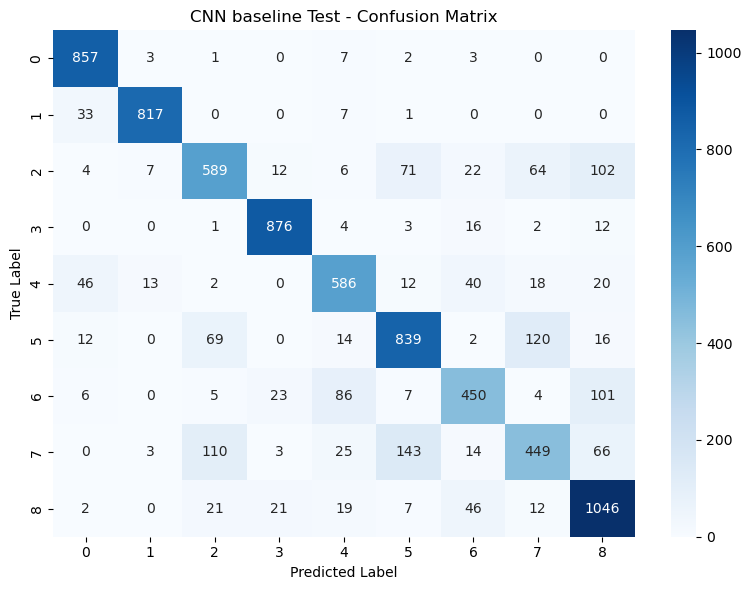

In [123]:
# predict result
cnn_baseline_pred = cnn_baseline.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
# The output of converting softmax
cnn_baseline_pred_labels = np.argmax(cnn_baseline_pred, axis=1)
# Output the overall result
evaluate_predictions(y_test_1hot, cnn_baseline_pred_labels, model_name="CNN baseline Test")

##### b.Remove or keep Dropout

In [125]:
# Define the model without Dropout
cnn_no_dp = build_cnn(dp=0)
cnn_no_dp.fit(X_dev_train, y_train_1hot, validation_data=(X_val, y_val_1hot), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stop])

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3252 - loss: 1.7775 - val_accuracy: 0.5195 - val_loss: 1.2221
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5534 - loss: 1.1899 - val_accuracy: 0.6295 - val_loss: 0.9880
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6256 - loss: 1.0052 - val_accuracy: 0.6388 - val_loss: 0.9676
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6581 - loss: 0.9304 - val_accuracy: 0.6641 - val_loss: 0.9032
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6873 - loss: 0.8689 - val_accuracy: 0.6784 - val_loss: 0.8658
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7032 - loss: 0.8171 - val_accuracy: 0.6966 - val_loss: 0.8135
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7249 - loss: 0.7693 - val_accuracy: 0.7034 - val_loss: 0.8022
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7396 - loss: 0.7313 - val_accu

In [126]:
cnn_no_dp_pred = cnn_no_dp.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

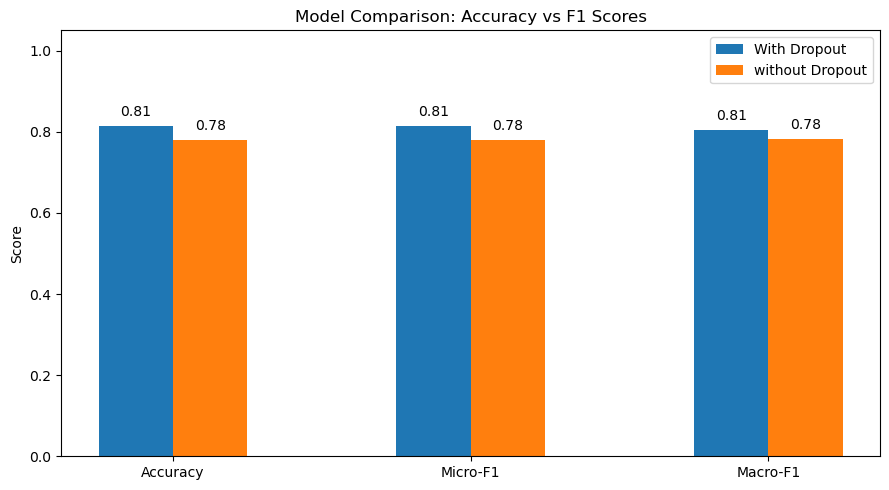

In [127]:
# Compare model with or without Dropout
compare_models_metrics(y_test_1hot, cnn_baseline_pred, cnn_no_dp_pred, model_names=["With Dropout", "without Dropout"])

##### c.Reduce the number of convolution-pooling blocks
- Remove block2

In [129]:
# Remove block2
cnn_block1 = build_cnn(block=1)
cnn_block1.fit(X_dev_train, y_train_1hot, validation_data=(X_val, y_val_1hot), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stop])

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2948 - loss: 1.8814 - val_accuracy: 0.5000 - val_loss: 1.3233
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4788 - loss: 1.3622 - val_accuracy: 0.5700 - val_loss: 1.1261
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5498 - loss: 1.1913 - val_accuracy: 0.6316 - val_loss: 1.0026
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5903 - loss: 1.0908 - val_accuracy: 0.5998 - val_loss: 1.0322
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6117 - loss: 1.0533 - val_accuracy: 0.6289 - val_loss: 0.9944
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6353 - loss: 0.9964 - val_accuracy: 0.6189 - val_loss: 1.0004
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6412 - loss: 0.9863 - val_accuracy: 0.6587 - val_loss: 0.9132
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6536 - loss: 0.9489 - val_accuracy: 0.

In [130]:
# predict result
cnn_block1_pred = cnn_block1.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

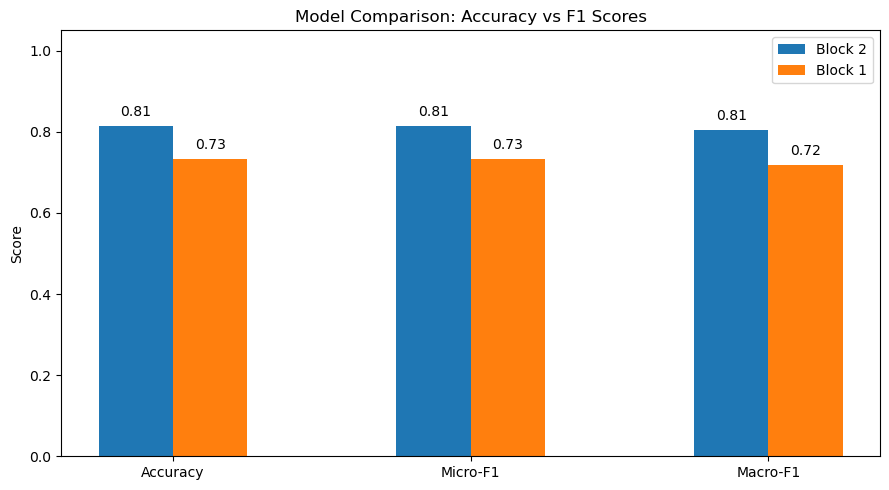

In [131]:
# Compare model with the number of convolution-pooling blocks
compare_models_metrics(y_test_1hot, cnn_baseline_pred, cnn_block1_pred, model_names=["Block 2", "Block 1"])

##### d.Replacement pooling method
- Comparison of MaxPool (emphasising the strongest activation) versus AvgPool (smooth downsampling) on feature retention and fine-grained information

In [133]:
# Change pooling method
avgpool_cnn = build_cnn(pool='avg')
avgpool_cnn.fit(X_dev_train, y_train_1hot, validation_data=(X_val, y_val_1hot), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stop])

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2809 - loss: 1.8791 - val_accuracy: 0.4348 - val_loss: 1.4879
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4928 - loss: 1.3425 - val_accuracy: 0.5889 - val_loss: 1.1661
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5770 - loss: 1.1429 - val_accuracy: 0.6072 - val_loss: 1.0557
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6199 - loss: 1.0200 - val_accuracy: 0.6323 - val_loss: 0.9853
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6512 - loss: 0.9405 - val_accuracy: 0.6278 - val_loss: 1.0122
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6741 - loss: 0.8896 - val_accuracy: 0.6770 - val_loss: 0.8813
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6932 - loss: 0.8376 - val_accuracy: 0.7139 - val_loss: 0.7783
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7129 - loss: 0.7860 - val_accu

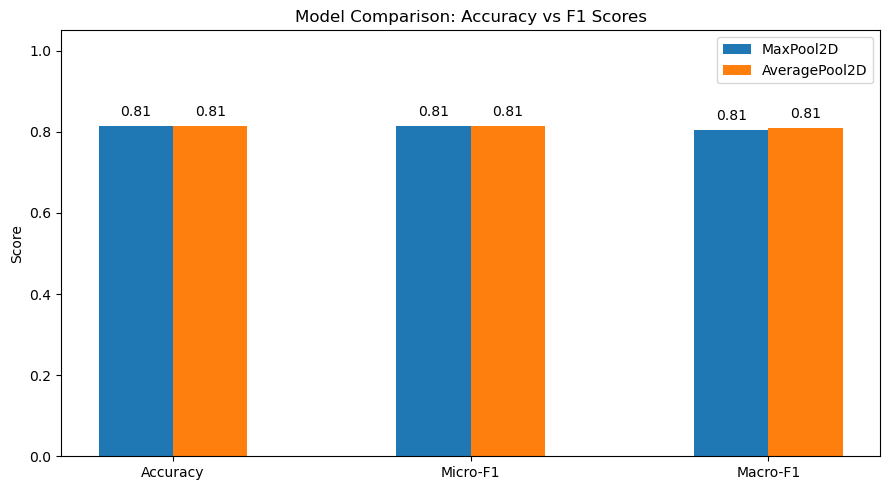

In [134]:
# predict result
avgpool_cnn_pred = avgpool_cnn.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
# Compare model with the size of convolution kernel 
compare_models_metrics(y_test_1hot, cnn_baseline_pred, avgpool_cnn_pred, model_names=["MaxPool2D", "AveragePool2D"])

##### e.Replacement activation function
- Baseline model use ReLU activation
- Leaky ReLU replace ReLU activation
- Exponential Linear Unit(ELU) repace ReLU activation

In [136]:
# Using Leaky ReLU
leaky_relu_cnn = build_cnn(act='leaky_relu')
leaky_relu_cnn.fit(X_dev_train, y_train_1hot, validation_data=(X_val, y_val_1hot), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stop])

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3561 - loss: 1.6903 - val_accuracy: 0.6095 - val_loss: 1.0791
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5858 - loss: 1.1171 - val_accuracy: 0.6778 - val_loss: 0.9174
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6441 - loss: 0.9722 - val_accuracy: 0.6786 - val_loss: 0.8913
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6814 - loss: 0.8697 - val_accuracy: 0.6681 - val_loss: 0.9063
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7168 - loss: 0.7881 - val_accuracy: 0.6836 - val_loss: 0.8591
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7338 - loss: 0.7420 - val_accuracy: 0.7320 - val_loss: 0.7392
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7580 - loss: 0.6720 - val_accuracy: 0.7448 - val_loss: 0.7019
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7660 - loss: 0.6395 - val_accu

In [137]:
# Using ELU
elu_cnn = build_cnn(act='elu')
elu_cnn.fit(X_dev_train, y_train_1hot, validation_data=(X_val, y_val_1hot), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stop])

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3939 - loss: 1.6210 - val_accuracy: 0.5745 - val_loss: 1.1490
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5943 - loss: 1.1050 - val_accuracy: 0.6147 - val_loss: 1.0365
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6467 - loss: 0.9688 - val_accuracy: 0.6734 - val_loss: 0.9114
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6855 - loss: 0.8642 - val_accuracy: 0.7289 - val_loss: 0.7530
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7200 - loss: 0.7854 - val_accuracy: 0.7361 - val_loss: 0.7162
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7350 - loss: 0.7439 - val_accuracy: 0.7620 - val_loss: 0.6631
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7513 - loss: 0.6977 - val_accuracy: 0.7577 - val_loss: 0.6559
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7615 - loss: 0.6609 - val_accu

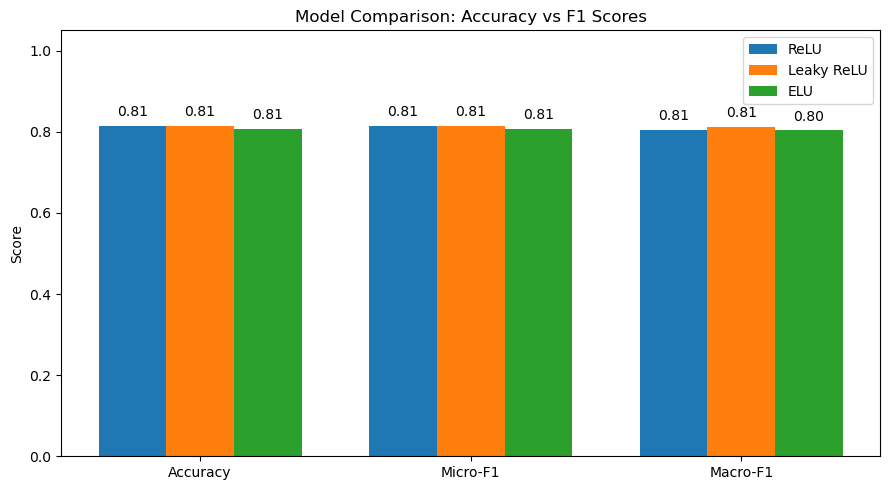

In [138]:
# predict result
leaky_relu_cnn_pred = leaky_relu_cnn.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
elu_cnn_pred = elu_cnn.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
# Compare model with different activation function
compare_models_metrics(y_test_1hot, cnn_baseline_pred, leaky_relu_cnn_pred, elu_cnn_pred , model_names=["ReLU", "Leaky ReLU", "ELU"])

##### f.Adjusting the number of fully connected layers
- Use 256 or 64 neurons to test the effect of feature spatial expressivity.

In [140]:
# Using 256 neurons on full leyer
CL256_cnn = build_cnn(CL_size= 256)
CL256_cnn.fit(X_dev_train, y_train_1hot, validation_data=(X_val, y_val_1hot), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stop])

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3181 - loss: 1.7907 - val_accuracy: 0.5650 - val_loss: 1.1785
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5750 - loss: 1.1274 - val_accuracy: 0.5786 - val_loss: 1.0892
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6356 - loss: 0.9953 - val_accuracy: 0.6484 - val_loss: 0.9409
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6621 - loss: 0.9198 - val_accuracy: 0.6231 - val_loss: 0.9953
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6933 - loss: 0.8459 - val_accuracy: 0.7083 - val_loss: 0.7880
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7216 - loss: 0.7771 - val_accuracy: 0.7331 - val_loss: 0.7364
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7422 - loss: 0.7136 - val_accuracy: 0.7456 - val_loss: 0.6963
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7547 - loss: 0.6842 - val_accu

In [141]:
# Using 64 neurons on full leyer
CL64_cnn = build_cnn(CL_size= 64)
CL64_cnn.fit(X_dev_train, y_train_1hot, validation_data=(X_val, y_val_1hot), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stop])

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2611 - loss: 1.9221 - val_accuracy: 0.5148 - val_loss: 1.3147
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4893 - loss: 1.3396 - val_accuracy: 0.5638 - val_loss: 1.1531
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5555 - loss: 1.1851 - val_accuracy: 0.6123 - val_loss: 1.0798
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6010 - loss: 1.0910 - val_accuracy: 0.6636 - val_loss: 0.9415
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6392 - loss: 0.9936 - val_accuracy: 0.6566 - val_loss: 0.9761
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6619 - loss: 0.9378 - val_accuracy: 0.7028 - val_loss: 0.8373
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6710 - loss: 0.9067 - val_accuracy: 0.7078 - val_loss: 0.8137
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6874 - loss: 0.8605 - val_accu

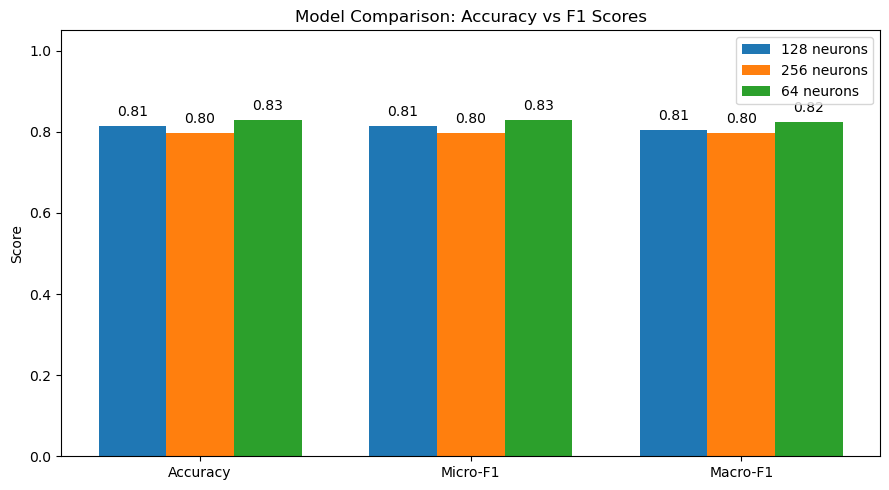

In [142]:
# predict result
CL256_cnn_pred = CL256_cnn.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
CL64_cnn_pred = CL64_cnn.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
# Compare model with the number of neurons
compare_models_metrics(y_test_1hot, cnn_baseline_pred, CL256_cnn_pred, CL64_cnn_pred , model_names=["128 neurons", "256 neurons", "64 neurons"])

##### g.Add batch normalisation
- Determine whether batch normalisation accelerates convergence and improves stability

In [144]:
# add BN
BN_cnn = build_cnn(use_bn= True)
BN_cnn.fit(X_dev_train, y_train_1hot, validation_data=(X_val, y_val_1hot), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stop])

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5711 - loss: 1.3031 - val_accuracy: 0.3698 - val_loss: 2.7551
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7522 - loss: 0.7015 - val_accuracy: 0.2552 - val_loss: 5.3520
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8068 - loss: 0.5461 - val_accuracy: 0.6227 - val_loss: 1.2312
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8387 - loss: 0.4497 - val_accuracy: 0.4764 - val_loss: 3.3084
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8620 - loss: 0.3768 - val_accuracy: 0.4231 - val_loss: 3.1724
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8766 - loss: 0.3425 - val_accuracy: 0.4739 - val_loss: 3.4929
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8969 - loss: 0.2835 - val_accuracy: 0.4841 - val_loss: 3.6335
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9113 - loss: 0.2459 - val_accu

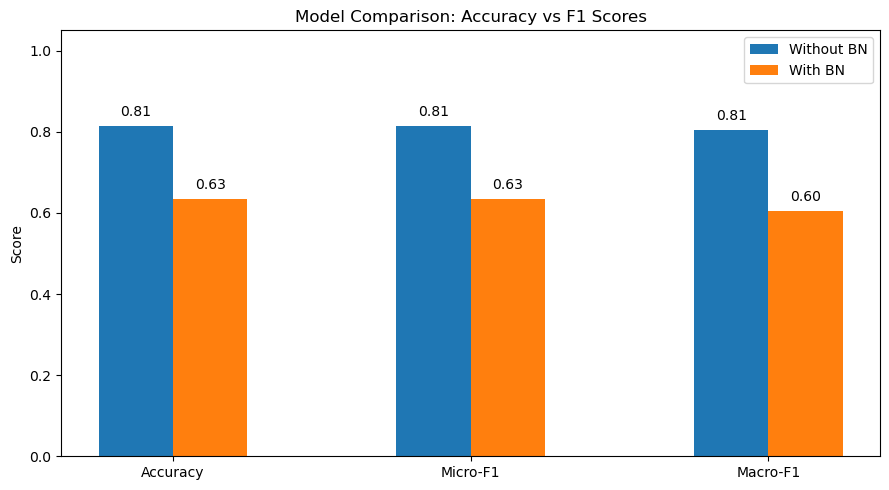

In [145]:
# predict result
BN_cnn_pred = BN_cnn.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
# Compare model with the size of convolution kernel 
compare_models_metrics(y_test_1hot, cnn_baseline_pred, BN_cnn_pred, model_names=["Without BN", "With BN"])

#### 3.3.2 Hyperparameter tuning on CNN
- Based on the results of the ablation study, since the dropout rate, activation functions, and number of neurons show similar performance, grid search is used to explore the best combination of parameters.
- Define the range of learning rate to do grid search
- Based on the results of the grid search, a heatmap is used to visualize the accuracy across different parameter combinations.

In [147]:
# Define the range of learning rate and Dropout rate 
cnn_clf = KerasClassifier(model=build_cnn, epochs=EPOCHS, batch_size=64, verbose=0, callbacks=[early_stop])
param_grid = {
    'model__learning_rate': [0.01, 0.001, 0.0001],
    'model__dp': [0.0, 0.2, 0.3],
    'model__act': ['relu','leaky_relu','elu'],
    'model__CL_size':[128,256],
}

In [148]:
grid_cnn = GridSearchCV(cnn_clf, param_grid, cv=3, scoring='accuracy')
grid_cnn.fit(X_dev_train, y_train_1hot, 
         **{'validation_data': (X_val, y_val_1hot)})

GridSearchCV(cv=3,
             estimator=KerasClassifier(batch_size=64, callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x3ab089700>], epochs=50, model=<function build_cnn at 0x3ab0571a0>, verbose=0),
             param_grid={'model__CL_size': [128, 256],
                         'model__act': ['relu', 'leaky_relu', 'elu'],
                         'model__dp': [0.0, 0.2, 0.3],
                         'model__learning_rate': [0.01, 0.001, 0.0001]},
             scoring='accuracy')

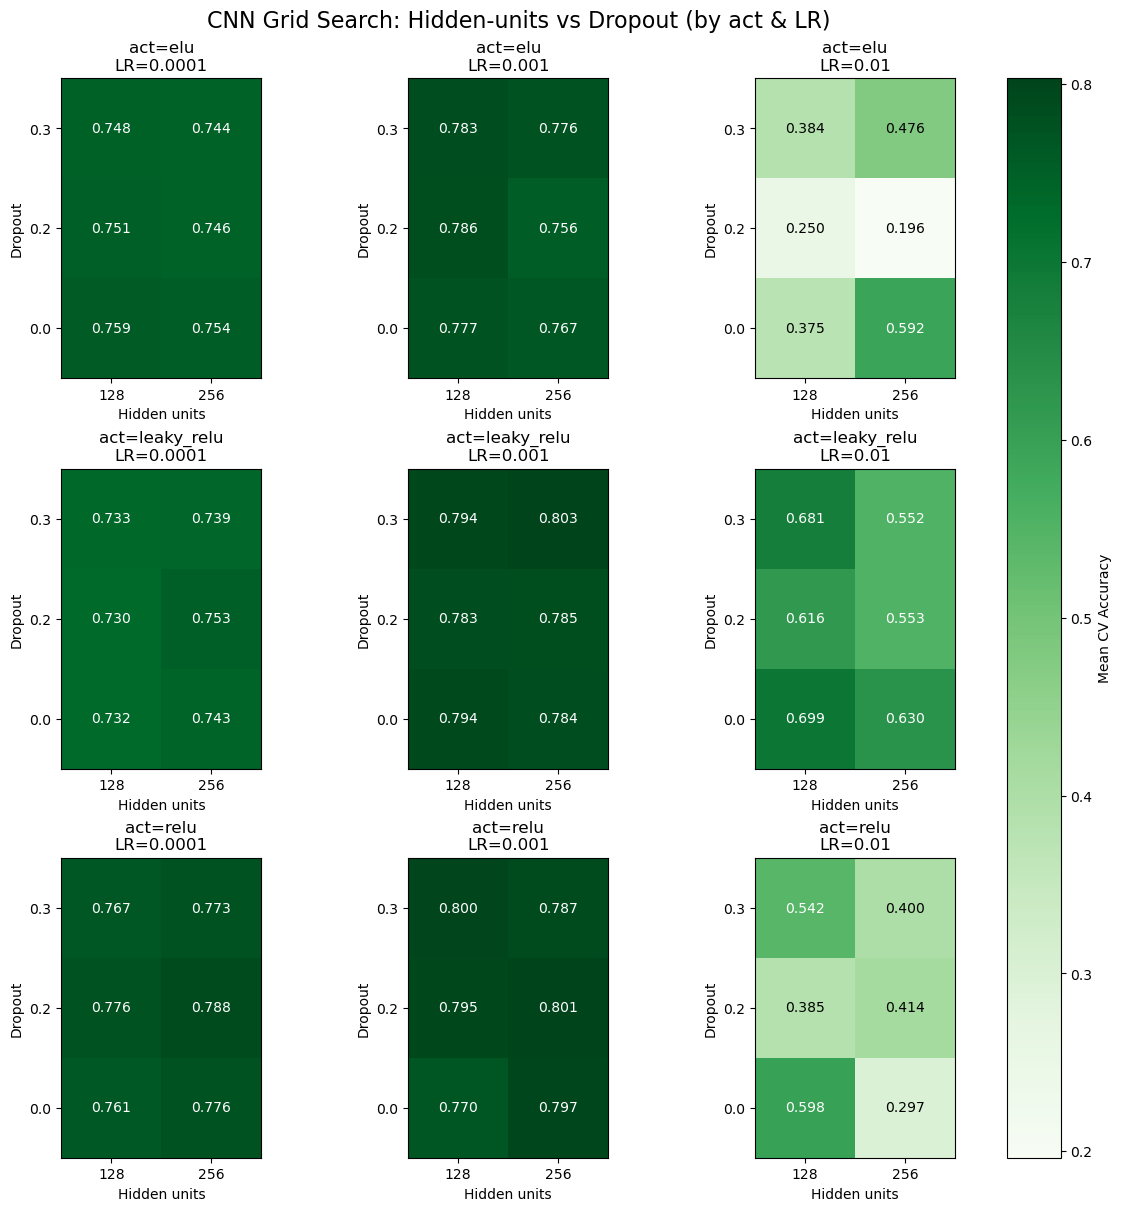

In [149]:
# Extract results
results = grid_cnn.cv_results_

# hyperparams
CLs  = sorted(np.unique(results['param_model__CL_size'].astype(int)))
dps  = sorted(np.unique(results['param_model__dp'].astype(float)))
lrs  = sorted(np.unique(results['param_model__learning_rate'].astype(float)))
acts = list(np.unique(results['param_model__act']))

# Prepare subplot grid
n_act, n_lr = len(acts), len(lrs)
fig, axes = plt.subplots(n_act, n_lr,
                         figsize=(4*n_lr, 4*n_act),
                         squeeze=False,
                         constrained_layout=True)

# For each activation × learning_rate, build & plot heatmap
vmin = results['mean_test_score'].min()
vmax = results['mean_test_score'].max()

for i, act in enumerate(acts):
    for j, lr in enumerate(lrs):
        ax = axes[i, j]

        # build matrix [dp × CL_size]
        mat = np.zeros((len(dps), len(CLs)))
        for ii, dp in enumerate(dps):
            for jj, cl in enumerate(CLs):
                mask = (
                    (results['param_model__act']            == act) &
                    (results['param_model__learning_rate'] == lr ) &
                    (results['param_model__dp']            == dp ) &
                    (results['param_model__CL_size']       == cl )
                )
                # pick the one entry
                mat[ii, jj] = results['mean_test_score'][mask][0]

        # plot
        im = ax.imshow(mat, origin='lower', cmap='Greens', vmin=vmin, vmax=vmax)
        ax.set_title(f"act={act}\nLR={lr}")
        ax.set_xticks(np.arange(len(CLs)))
        ax.set_xticklabels(CLs)
        ax.set_yticks(np.arange(len(dps)))
        ax.set_yticklabels(dps)
        ax.set_xlabel("Hidden units")
        ax.set_ylabel("Dropout")

        # annotate
        for ii in range(len(dps)):
            for jj in range(len(CLs)):
                ax.text(jj, ii, f"{mat[ii,jj]:.3f}",
                        ha='center', va='center', color='white' if mat[ii,jj]> (vmin+vmax)/2 else 'black')

# colorbar & supertitle
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), label="Mean CV Accuracy")
fig.suptitle("CNN Grid Search: Hidden‐units vs Dropout (by act & LR)", fontsize=16)
plt.show()

In [150]:
print("Best CNN params:", grid_cnn.best_params_)
print("Best CV accuracy:", grid_cnn.best_score_)

Best CNN params: {'model__CL_size': 256, 'model__act': 'leaky_relu', 'model__dp': 0.3, 'model__learning_rate': 0.001}
Best CV accuracy: 0.8032810998693932


#### 3.3.3 Show the runtime and result of different parameter combinations

In [152]:
# Showing the runtime and result of each combination.
# Turn result into a DataFrame
cnn_df = pd.DataFrame(grid_cnn.cv_results_)

# set columns
cnn_df = cnn_df[['params',
         'mean_test_score','std_test_score',
         'mean_fit_time','std_fit_time',
         'mean_score_time','std_score_time']]

#  Sort by average test score
cnn_df = cnn_df.sort_values('mean_test_score', ascending=False)

# Show Top 10
cnn_df = cnn_df.head(10)

# Reset the index and have it start at 1
cnn_df = cnn_df.reset_index(drop=True)
cnn_df.index = cnn_df.index + 1

cnn_df

,params,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
1,"{'model__CL_size': 256, 'model__act': 'leaky_r...",0.803281,0.005092,64.354329,2.049579,0.515221,0.001916
2,"{'model__CL_size': 256, 'model__act': 'relu', ...",0.801367,0.006226,72.116169,11.633163,0.475761,0.001587
3,"{'model__CL_size': 128, 'model__act': 'relu', ...",0.800117,0.006613,105.199403,11.233753,0.498615,0.003128
4,"{'model__CL_size': 256, 'model__act': 'relu', ...",0.796640,0.013646,66.985379,1.267927,0.527612,0.010978
5,"{'model__CL_size': 128, 'model__act': 'relu', ...",0.795273,0.012484,89.343180,21.224100,0.581627,0.124555
6,"{'model__CL_size': 128, 'model__act': 'leaky_r...",0.794297,0.008718,61.858815,1.618912,0.485053,0.016586
7,"{'model__CL_size': 128, 'model__act': 'leaky_r...",0.793672,0.002650,59.762714,7.161489,0.529888,0.034331
8,"{'model__CL_size': 256, 'model__act': 'relu', ...",0.788203,0.008649,138.845134,7.081856,0.486936,0.003954
9,"{'model__CL_size': 256, 'model__act': 'relu', ...",0.786992,0.009598,54.810836,3.332785,0.491856,0.000991
10,"{'model__CL_size': 128, 'model__act': 'elu', '...",0.786446,0.004607,71.051523,7.742011,0.581529,0.018832


## 4. Final models
- Use best parameters to train each model.
- Comparsion of model performance.
    - Model performance is compared using Accuracy, Micro-F1, and Macro-F1 metrics.
    - Compare the training time of the models
    - Compare the confusion matrix of the models
    - Compare the accuracy and loss of the models on train and validataion set.

### 4.1 Use best parameters to train each model

#### 4.1.1 SVM

In [156]:
# record train start time
svm_start_time = time.time()

# train best model on svm
best_svm = SVC(kernel="rbf", gamma='scale', C = 10)
best_svm.fit(X_train_pca, y_train_clean)

# record train end time
svm_end_time = time.time()

In [157]:
# predict result
best_svm_pred = best_svm.predict(X_test_pca)
# calculate training time
svm_time = round(svm_end_time - svm_start_time, 2)

#### 4.1.2 Fully connected neural network

In [159]:
# Stop the configuration in advance
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# record train start time
mlp_start_time = time.time()

# train best model on MLP
best_mlp = create_mlp_model(hidden_units=[512, 256, 128],dropout_rate=0.5,learning_rate=0.001,activation='relu',kernel_regularizer=regularizers.l2(1e-4))
history_best_mlp = best_mlp.fit(X_train_pca, y_train_clean_1hot,
    validation_data=(X_val_pca, y_val_1hot),epochs=50,
    batch_size=128,
    callbacks=[early_stop])

# record train end time
mlp_end_time = time.time()

Epoch 1/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1497 - loss: 2.3653 - val_accuracy: 0.3705 - val_loss: 1.7569
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3456 - loss: 1.7729 - val_accuracy: 0.4805 - val_loss: 1.4049
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4225 - loss: 1.5212 - val_accuracy: 0.5116 - val_loss: 1.3318
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4663 - loss: 1.4165 - val_accuracy: 0.5355 - val_loss: 1.2774
Epoch 5/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5011 - loss: 1.3480 - val_accuracy: 0.5517 - val_loss: 1.2429
Epoch 6/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5231 - loss: 1.2967 - val_accuracy: 0.5587 - val_loss: 1.2175
Epoch 7/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5469 - loss: 1.2559 - val_accuracy: 0.5698 - val_loss: 1.1981
Epoch 8/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5539 - loss: 1.2265 - val_accuracy: 0.

In [160]:
# predict result
best_mlp_pred = best_mlp.predict(X_test_pca, batch_size=128, verbose=0)
# calculate training time
mlp_time = round(mlp_end_time - mlp_start_time, 2)

#### 4.1.3 Convolutional neural network

In [162]:
# record train start time
cnn_start_time = time.time()

# train best model on CNN
best_cnn = build_cnn(dp=0.3, learning_rate=0.001,block=2,  kernel_size = 3, pool = 'max', act = 'leaky_relu', CL_size = 128, use_bn = False)
history_best_cnn =best_cnn.fit(X_dev_train, y_train_1hot, validation_data=(X_val, y_val_1hot), epochs=50, batch_size=64, callbacks=[early_stop]) 

# record train end time
cnn_end_time = time.time()

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3221 - loss: 1.7694 - val_accuracy: 0.5480 - val_loss: 1.1763
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5696 - loss: 1.1589 - val_accuracy: 0.6509 - val_loss: 0.9897
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6431 - loss: 0.9726 - val_accuracy: 0.6659 - val_loss: 0.9300
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6810 - loss: 0.8814 - val_accuracy: 0.7202 - val_loss: 0.8105
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7047 - loss: 0.8126 - val_accuracy: 0.6942 - val_loss: 0.8355
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7261 - loss: 0.7576 - val_accuracy: 0.6902 - val_loss: 0.8434
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7421 - loss: 0.7021 - val_accuracy: 0.7441 - val_loss: 0.7149
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7602 - loss: 0.6649 - val_accu

In [163]:
# predict result
best_cnn_pred = best_cnn.predict(X_test, batch_size=64, verbose=0)
# calculate training time
cnn_time = round(cnn_end_time - cnn_start_time, 2)

### 4.2 Comparsion of model performance

#### 4.2.1 Accuracy, Micro-F1, and Macro-F1 metrics.

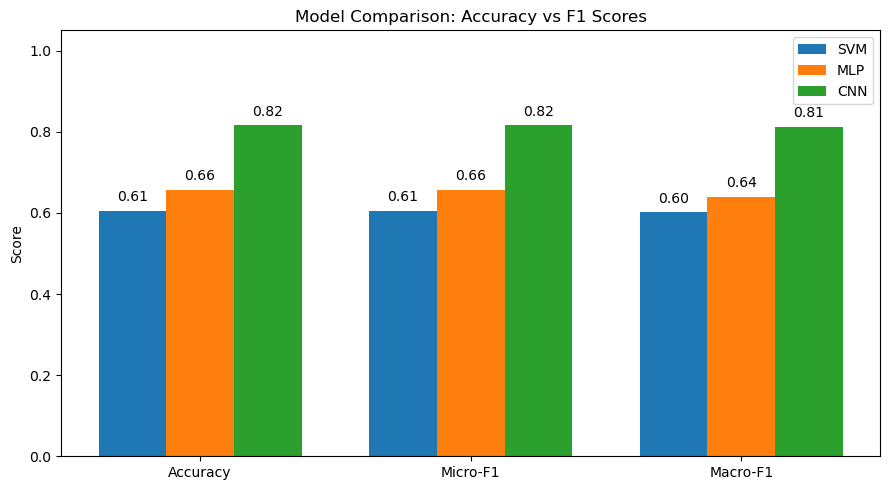

In [166]:
compare_models_metrics(
    y_true=y_test_1hot,
    y_pred1=best_svm_pred,
    y_pred2=best_mlp_pred,
    y_pred3=best_cnn_pred,
    model_names=["SVM", "MLP", "CNN"]
)

#### 4.2.2 Training time

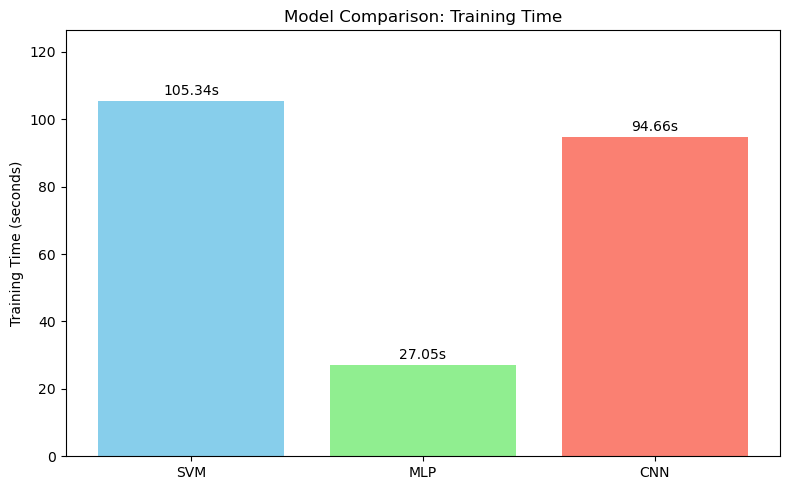

In [168]:
# Model name and corresponding time
models = ['SVM', 'MLP', 'CNN']
train_times = [svm_time, mlp_time, cnn_time]

# plot
plt.figure(figsize=(8, 5))
bars = plt.bar(models, train_times, color=['skyblue', 'lightgreen', 'salmon'])

# Add numeric labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.2f}s', 
             ha='center', va='bottom', fontsize=10)

plt.ylabel('Training Time (seconds)')
plt.title('Model Comparison: Training Time')
plt.ylim(0, max(train_times)*1.2)
plt.tight_layout()
plt.show()

#### 4.2.3 Confusion matrix

In [170]:
def create_CM_safe(y_true, y_pred, model_name="Model"):
    def to_label(y):
        return np.argmax(y, axis=1) if y.ndim > 1 else y

    # Automatically handle one-hot → tags
    y_true = to_label(y_true)
    y_pred = to_label(y_pred)

    # Generate confusion matrix
    create_CM(y_true, y_pred, model_name=model_name)

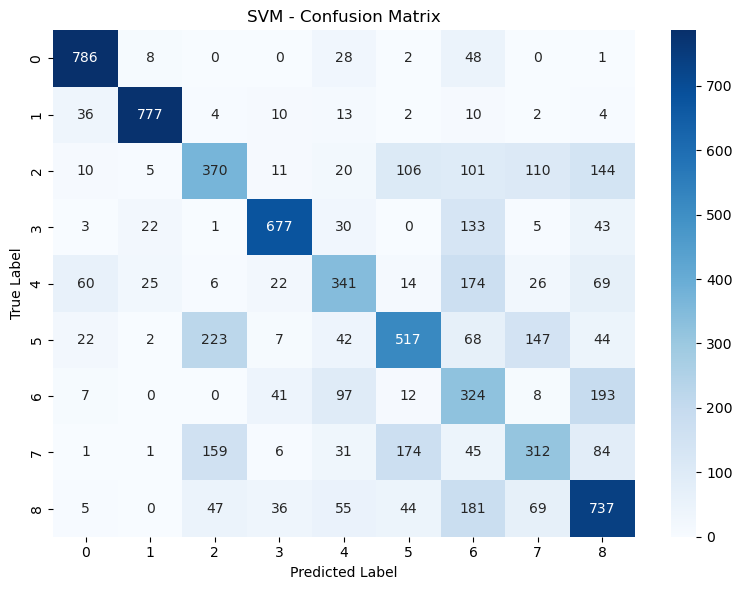

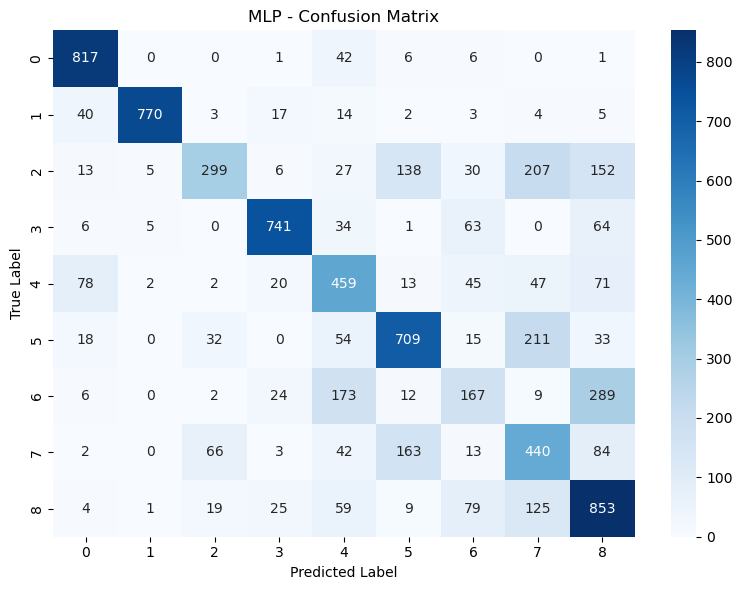

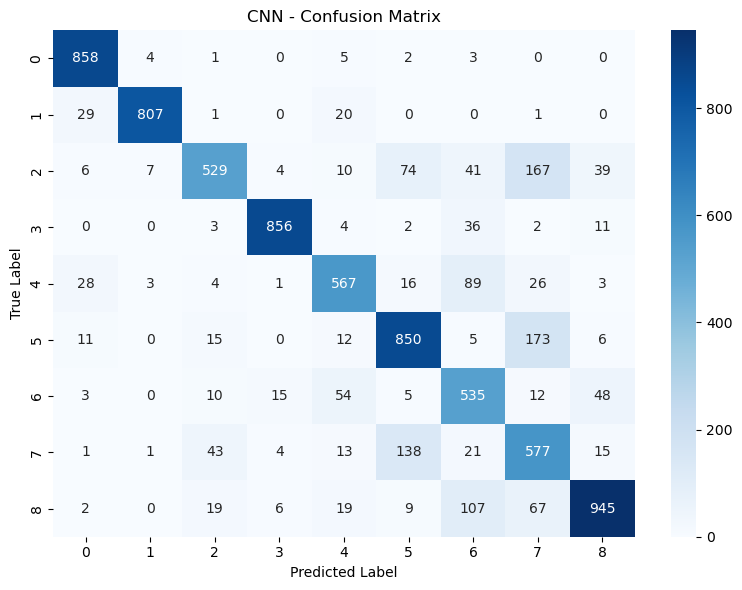

In [171]:
create_CM(y_test,best_svm_pred,'SVM')
create_CM_safe(y_test_1hot,best_mlp_pred,'MLP')
create_CM_safe(y_test_1hot,best_cnn_pred,'CNN')

#### 4.2.4 Comparison of MLP and CNN

In [173]:
# create plot
def plot_compare_histories(history_mlp, history_cnn):
    epochs_mlp = range(1, len(history_mlp.history['accuracy']) + 1)
    epochs_cnn = range(1, len(history_cnn.history['accuracy']) + 1)

    plt.figure(figsize=(14, 6))

    # Accuracy Comparison Chart
    plt.subplot(1, 2, 1)
    plt.plot(epochs_mlp, history_mlp.history['accuracy'], color='dodgerblue', label='MLP Train Acc')
    plt.plot(epochs_mlp, history_mlp.history['val_accuracy'], color='lightskyblue', label='MLP Val Acc')
    plt.plot(epochs_cnn, history_cnn.history['accuracy'], color='darkorange', label='CNN Train Acc')
    plt.plot(epochs_cnn, history_cnn.history['val_accuracy'], color='gold', label='CNN Val Acc')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Comparison Chart
    plt.subplot(1, 2, 2)
    plt.plot(epochs_mlp, history_mlp.history['loss'], color='crimson', label='MLP Train Loss')
    plt.plot(epochs_mlp, history_mlp.history['val_loss'], color='salmon', label='MLP Val Loss')
    plt.plot(epochs_cnn, history_cnn.history['loss'], color='seagreen', label='CNN Train Loss')
    plt.plot(epochs_cnn, history_cnn.history['val_loss'], color='mediumseagreen', label='CNN Val Loss')
    plt.title('Model Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

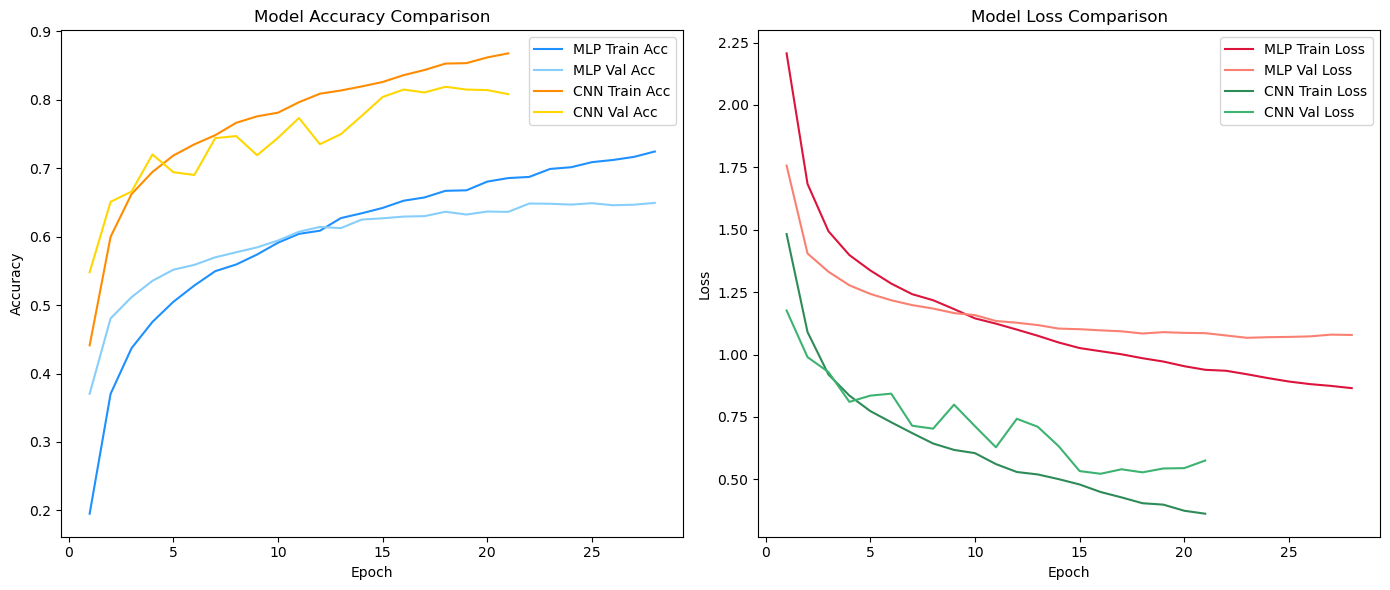

In [174]:
plot_compare_histories(history_best_mlp, history_best_cnn)